# E-commerce — Выявление профилей потребления

# Декомпозиция v2

**Описание проекта:**  
В роли аналитика интернет-магазина товаров для дома «Пока все ещё тут» необходимо провести исследование, сегментировать покупателей по профилю потребления. Полученные результаты помогут маркетологам создать индивидуальное предложение для каждого потребителя, в роли предложения могут быть почтовая рассылка, лендинг, подборка в каталоге, размер скидки, рекомендации по контенту.

**Описание данных:**  
Для исследования был предоставлен файл "ecommerce_dataset.csv" с данными о транзакциях интернет-магазина: 

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.


**Цель исследования:**  
Сегментировать покупателей, с учётом поведенческих характеристик на основе истории их покупок в интернет-магазине товаров для дома «Пока все ещё тут».

**Задачи исследования:**
1. Первичный анализ входных данных (шаг заключается в изучении описательных характеристик данных)
- импорт библиотек
- чтение датафрейма
- оценка общих данных датафрейма

2. Предобработка данных (шаг заключается в повышении качества данных, с целью сделать их пригодными для дальнейшего исследовательского анализа)
- приведение данных к единому регистру
- переформатирование данных
- работа с явными и неявными дубликатами (если есть)
- работа с пропусками (если есть)
- идентификация выбросов и сглаживание зашумленных данных
- добавление столбцов с данными год/месяц/день недели/час
- добавление столбца с выручкой

3. Исследовательский анализ данных (шаг заключается в выявлении тенденций, закономерностей или проверки предположений с помощью статистических сводок и графических представлений)
- выделение категорий товаров
- анализ распределения категорий товаров
- анализ среднего чека по категориям
- анализ общей выручки по категориям
- анализ выручки по категориям с разбивкой по месяцам
- анализ выручки по категориям с разбивкой по дням недели
- анализ выручки по категориям с разбивкой по времени суток
- исследование количества заказов с разбивкой по месяцам
- исследование количества заказов с разбивкой по дням недели
- исследование количества заказов с разбивкой по времени суток
- анализ топ-5 продаваемых товаров по количеству
- анализ топ-5 продаваемых товаров по выручке
- анализ сезонности для категорий товаров

4. Сегментация покупателей (шаг заключается в разделении множества покупателей так, чтобы похожие по своему поведению покупатели попали в одну и ту же категорию, а покупатели из разных категорий существенно различались между собой, что позволит выявить определенные характеристики и закономерности для категорий покупателей)</span>
- построение дендрограммы
- обучение модели кластеризации и прогнозирование кластеров на основе параметров: кол-во заказов, кол-во товаров, выручка, средн. стоимость товара, категории товаров.
- проведение кластеризации пользователей методом DBSCAN
- сравнение кластеров по бизнес показателям
- анализ сезонности популярных категорий по получившимся кластерам

5. Проверка статистических гипотез (шаг заключается в проверке предположения о целесообразности перекрестных продаж -  можно ли в момент покупки клиенту предлагать приобрести кроме основного товара еще и сопутствующие товары из другой категории)
- формирование независимых выборок из кластеров для проверки гипотез 
- проверка статистической значимости различий в средней выручке между кластерами (Н0 - Между средней выручкой кластеров нет существенной разницы, Н1 - Между средней выручкой кластеров есть существенная разница.)
- проверка статистической значимости различий в средней стоимости товара в заказе между кластерами (Н0 - Между средней стоимостью товаров кластеров нет существенной разницы, Н1 - Между средней стоимостью товаров кластеров есть существенная разница.)
- проведение проверочного теста ANOVA

6. Общий вывод с рекомендациями

# Первичный анализ входных данных

In [101]:
#импортируем необходимые библиотеки
import re
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta

import plotly.express as px
from plotly import graph_objects as go

#ML
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import pdist
from scipy.stats import mannwhitneyu
from sklearn.cluster import DBSCAN

#игнорирование предупреждений и ошибок при компиляции/запуске кода
import warnings
warnings.filterwarnings('ignore')

#отображение всех чисел с двумя знаками после запятой
pd.set_option('display.float_format', '{:.2f}'.format)

In [102]:
store = pd.read_csv('store.csv')
store

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00
...,...,...,...,...,...,...
6732,2019103111,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.00
6733,2019103112,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.00
6734,2019103113,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.00
6735,2019103114,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.00


In [103]:
#выведем первые 10 строк датафрейма
display(store.head(10))
#выведем рандомные 10 строк датафрейма
display(store.sample(10))
#выведем последние 10 строк датафрейма
display(store.tail(10))

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.00
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.00
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.00
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.00
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.00


,date,customer_id,order_id,product,quantity,price
312,2018101817,3de09660-90bc-4a28-aaf1-34c8435fe59c,68683,"Таз пластмассовый 20,0 л пищевой (Минеральные ...",1,277.00
1841,2019021610,c850ba6d-b3b8-4052-bda4-b23c11fa5fba,70286,Сушилка для белья на ванну НИКА СБ4,1,449.00
5716,2019070710,4abe913b-6deb-40d9-9f78-a387ecc737f9,71894,Пеларгония зональная Ринго Вайт d-7 см h-10 см...,1,74.00
3449,2019050813,77b16868-3a9e-4238-a347-db456ccab902,14734,Вероника колосковая микс объем 1 л,1,97.00
2883,2019041613,0184f535-b60a-4914-a982-231e3f615206,14649,Петуния Surprice Yellow желтая с прожилками об...,1,90.00
2932,2019041720,f83eedd3-aaad-48ed-9977-55f6046477a3,14655,"Лобелия ампельная, диам. 12 см",1,142.00
4598,2019060509,7d5d5657-5fdc-40d1-b7b6-bb04ede92b53,14848,Роза садовая чайногибридная в горшке Черри Бренди,1,188.00
6246,2019090408,f978b6ac-c601-49d9-9700-833330a4616a,72500,"Чайник со свистком Attribute DERBY 2,5 л ASS305",1,1049.00
5041,2019061020,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурец Кристина ячейки по 6 шт Е6,1,120.00
5855,2019071318,9fc8845e-5683-401a-8125-ac73116f442e,71860,Подкладка под чехол Zalger 520114 135х50 см во...,2,127.00


,date,customer_id,order_id,product,quantity,price
6727,2019103021,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.00
6728,2019103100,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.00
6729,2019103102,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.00
6730,2019103109,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.00
6731,2019103111,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.00
6732,2019103111,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.00
6733,2019103112,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.00
6734,2019103113,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.00
6735,2019103114,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.00
6736,2019103116,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.00


In [104]:
#проверим типы столбцов и количество непропущенных значений
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [105]:
#посмотрим описательную статистику каждого столбца в датафрейме
store.describe(include='all')

,date,customer_id,order_id,product,quantity,price
count,6737.00,6737,6737.00,6737,6737.00,6737.00
unique,NaN,2451,NaN,2343,NaN,NaN
top,NaN,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,NaN,Рассада Кабачка сорт Зебра кассета 6 шт E6,NaN,NaN
freq,NaN,888,NaN,79,NaN,NaN
mean,2018854551.37,NaN,43128.95,NaN,2.50,462.03
std,385518.47,NaN,27899.41,NaN,15.27,871.30
min,2018100100.00,NaN,12624.00,NaN,1.00,9.00
25%,2019020413.00,NaN,14827.00,NaN,1.00,101.00
50%,2019050216.00,NaN,68503.00,NaN,1.00,135.00
75%,2019061022.00,NaN,70504.00,NaN,1.00,398.00


In [106]:
#проверим на наличие явных дубликатов
print('Количество дубликатов:',store.duplicated().sum())

Количество дубликатов: 0


In [107]:
store.nunique()

date           2606
customer_id    2451
order_id       2784
product        2343
quantity         49
price           360
dtype: int64

## Предварительные выводы

1. Нужно изменить формат даты
2. В датафрейме 6737 строк b 6 столбцов
3. Нет пропусков
4. Нет явных дубликатов
5. Нужно привести наименования товаров `product` к единому нижнему регистру
6. Уникальных покупателей 2451
7. Чаще всего покупки совершает покупатель с идентификатором 1d6c8c1f-a799-4418-9af2-1ded47d7a85c - 888 частота упоминаний
8. 2343 уникальных наименований товаров, из них самый популярный товар - Рассада Кабачка сорт Зебра кассета 6 шт E6, 79 упоминаний
9. Среднее количество товаров в заказе 2
10. Средняя стоимость товара 462 рубля
11. Минимальная цена товара 9 руб, максимальная цена товара 14917
12. Минимальное количество проданных товаров одному покупателю 1, максимальное - 1000

# Предобработка данных

## Приведем наименования товаров к нижнему регистру

In [108]:
#приведем столбец product к нижнему регистру
store['product']=store['product'].str.lower()

## Изменение типов данных и добавление новых столбцов

In [109]:
#преобразуем тип данных price с float на int
store['price'] = store['price'].astype('int')

In [110]:
#преобразуем тип данных date с int64 на datetime64
store['date'] = pd.to_datetime(store['date'], format = '%Y%m%d%H')

#добавим столбец c годом
store['year'] = store['date'].dt.year
#добавим столбец c неделей
store['week'] = store['date'].dt.isocalendar().week
#добавим столбец c месяцем
store['month'] = store['date'].dt.month
#добавим столбец c часами
store['hour'] = store['date'].dt.hour
#добавим столбец c днем недели
store['day_of_week'] = store['date'].dt.day_name()

In [111]:
#добавим столбец c выручкой от продажи с каждого товара
store['revenue'] = store['price'] * store['quantity']

## Посмотрим за какой период представлены данные в датасете

In [112]:
print('Минимальная дата зафиксированного события:', store['date'].min())
print('Максимальная дата зафиксированного события:', store['date'].max())
print(f"Данные представлены за период: {store['date'].max() - store['date'].min()}")

Минимальная дата зафиксированного события: 2018-10-01 00:00:00
Максимальная дата зафиксированного события: 2019-10-31 16:00:00
Данные представлены за период: 395 days 16:00:00


## Очистим данные от дубликатов

In [113]:
print('Количество дубликатов: {:.0f}'.format(store.duplicated().sum()))

Количество дубликатов: 0


In [114]:
store[store.duplicated(subset=['customer_id', 'order_id', 'product'])].count()

date           1886
customer_id    1886
order_id       1886
product        1886
quantity       1886
price          1886
year           1886
week           1886
month          1886
hour           1886
day_of_week    1886
revenue        1886
dtype: int64

In [115]:
shape_table=(store.shape)

In [116]:
store.loc[store.duplicated(subset=['customer_id', 'order_id', 'product'])].sort_values(by=['order_id', 'product']).tail(40)

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
6394,2019-09-22 12:00:00,0fa91725-559a-4cc8-877c-9636d6822abf,72720,блюдо pasabahce серия конья диаметр 354 мм 54372b,1,262,2019,38,9,12,Sunday,262
6395,2019-09-22 13:00:00,0fa91725-559a-4cc8-877c-9636d6822abf,72720,блюдо pasabahce серия конья диаметр 354 мм 54372b,1,262,2019,38,9,13,Sunday,262
6398,2019-09-22 14:00:00,0fa91725-559a-4cc8-877c-9636d6822abf,72720,блюдо pasabahce серия конья диаметр 354 мм 54372b,1,262,2019,38,9,14,Sunday,262
6402,2019-09-22 16:00:00,0fa91725-559a-4cc8-877c-9636d6822abf,72720,блюдо pasabahce серия конья диаметр 354 мм 54372b,1,262,2019,38,9,16,Sunday,262
6418,2019-09-24 10:00:00,4449910f-c189-41ee-96b3-f7fc9edf25f6,72744,тележка багажная delta dt-22 синий грузоподъем...,1,674,2019,39,9,10,Tuesday,674
6424,2019-09-25 10:00:00,30c7d384-dd5b-4477-83b9-2e67c0a70e37,72753,"комнатное растение в горшке плющ, хедера салат...",1,299,2019,39,9,10,Wednesday,299
6472,2019-09-29 19:00:00,05f74c6f-2395-45ac-a826-9e070652de3e,72786,коврик придверный apache 45х76 см flagstone 5415,1,1199,2019,39,9,19,Sunday,1199
6449,2019-09-28 13:00:00,a3d7fb5c-d3fb-40d6-b060-47a7061ca442,72790,сушилка для белья потолочно-настенная gimi lif...,1,1424,2019,39,9,13,Saturday,1424
6486,2019-10-01 16:00:00,0adba506-249c-40b5-839d-a59d7a275cd7,72824,пеларгония зональная ринго вайт d-7 см h-10 см...,1,74,2019,40,10,16,Tuesday,74
6501,2019-10-02 22:00:00,0adba506-249c-40b5-839d-a59d7a275cd7,72824,пеларгония зональная ринго вайт d-7 см h-10 см...,1,74,2019,40,10,22,Wednesday,74


In [117]:
store.loc[store.duplicated(subset=['customer_id', 'order_id', 'product'], keep=False)].sort_values(by=['date']).head()

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"мини-сковорода marmiton ""сердце"" с антипригарн...",1,239,2018,40,10,18,Monday,239
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,сковорода алюминиевая с антипригарным покрытие...,1,824,2018,40,10,18,Monday,824
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,стеклянная крышка для сковороды alpenkok 26 см...,1,262,2018,40,10,18,Monday,262
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"сушилка для белья напольная colombo star 18, 3679",1,1049,2018,40,10,18,Monday,1049
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,2018,40,10,21,Monday,3299


In [118]:
store.loc[store.duplicated(subset=['customer_id', 'order_id', 'product'], keep=False)].sort_values(by=['date']).tail()

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397,2019,44,10,7,Wednesday,397
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087,2019,44,10,9,Wednesday,1087
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397,2019,44,10,0,Thursday,397
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397,2019,44,10,2,Thursday,397
6736,2019-10-31 16:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087,2019,44,10,16,Thursday,1087


In [119]:
store.loc[store['customer_id'] == '344aa778-e436-419e-a9c6-9b8f37b7c1df']

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087,2019,44,10,9,Wednesday,1087
6736,2019-10-31 16:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087,2019,44,10,16,Thursday,1087


В датасете есть заказы, которые повторяются по несколько раз, но с разными датами. Оставим только первые записи по задублированным заказам

In [120]:
store.drop_duplicates(subset=['customer_id', 'order_id', 'product'], keep='first', inplace=True)

In [121]:
store[store.duplicated(subset=['customer_id', 'order_id', 'product'])].count()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
year           0
week           0
month          0
hour           0
day_of_week    0
revenue        0
dtype: int64

In [122]:
shape_table_update=(store.shape)

In [123]:
shape_table_update=(store.shape)
if shape_table ==shape_table_update:
    print('Размер таблицы не изменился, текущий размер:',shape_table_update)
else:
    print('Таблица уменьшилась, текущий размер:',shape_table_update)

Таблица уменьшилась, текущий размер: (4851, 12)


In [124]:
print('Доля удалённых дубликатов: {:.0f}'.format(1886/6737*100),'%')

Доля удалённых дубликатов: 28 %


In [125]:
print('Количество дубликатов: {:.0f}'.format(store.duplicated().sum()))

Количество дубликатов: 0


In [126]:
#проверим результат на одном из клиентов
store.loc[store['customer_id'] == 'd90fe616-af94-485d-8de8-4b94df1fa685']

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
4125,2019-05-29 20:00:00,d90fe616-af94-485d-8de8-4b94df1fa685,71549,пеларгония розебудная red pandora укорененный ...,1,134,2019,22,5,20,Wednesday,134
6590,2019-10-12 09:00:00,d90fe616-af94-485d-8de8-4b94df1fa685,72940,пеларгония розебудная apple blossom укорененны...,1,149,2019,41,10,9,Saturday,149


## Очистим данные от выбросов

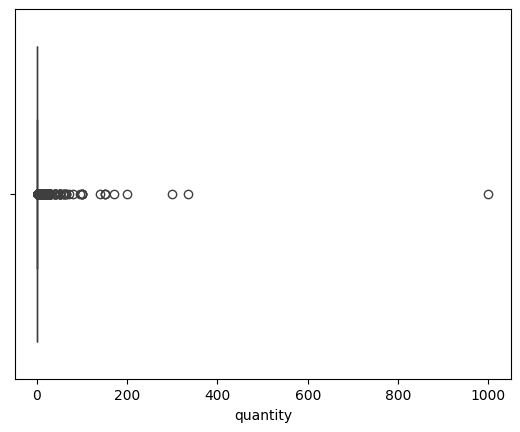

In [127]:
#проверим на аномалии столбец quantity
sns.boxplot(x=store["quantity"]);

In [128]:
#посмотрим на оптовые заказы, в которых количество товара превышает 100 единиц
store.loc[store['quantity'] > 100]

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19,2018,41,10,14,Thursday,2850
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38,2018,41,10,14,Thursday,5700
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51,2018,44,11,8,Thursday,8670
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59,2018,44,11,11,Friday,8260
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29,2018,50,12,14,Monday,5800
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,плечики пластмассовые размер 52 - 54 тула 1205158,150,20,2019,12,3,10,Saturday,3000
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51,2019,21,5,21,Monday,15300
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148,2019,24,6,7,Tuesday,49432
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675,2019,25,6,15,Tuesday,675000


In [129]:
#удалим оптовые заказы из выборки
store = store.loc[store['quantity'] <= 100]

#проверим результат
store.loc[store['quantity'] > 100]

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue


При сегментации покупателей по поведению в интернет-магазине целью является выделение групп покупателей с определенными характеристиками и поведением, чтобы определить наиболее эффективные маркетинговые стратегии для каждой группы.
    Крупные оптовые заказы могут исказить результаты сегментации, потому что они не отражают типичное поведение обычного потребителя. Такие заказы могут сделать покупателя похожим на корпоративного клиента, вместо того, чтобы отразить их реальные потребности и интересы.
    Кроме того, крупные оптовые заказы могут быть неоднородными и включать различные продукты, что затрудняет определение конкретных предпочтений или характеристик группы покупателей.
    Исключение крупных оптовых заказов при сегментации позволяет получить более точную картину поведения обычных покупателей, что в свою очередь поможет более точно определить их потребности и создать более эффективные маркетинговые стратегии.
Также, крупные оптовые заказы в выборке могут плохо повлиять на дальнейшую кластеризацию методом k-means. Крупные оптовые заказы могут существенно влиять на средние значения признаков и на расстояния между точками данных, если эти заказы не будут учитываться при кластеризации, то алгоритм k-means может присвоить им собственный кластер или привести к тому, что все остальные точки будут отнесены к одному кластеру т.к. они будут сильно отличаться от остальных точек в выборке, что может привести к неоптимальным результатам кластеризации. Поэтому, чтобы получить более точные результаты при кластеризации методом k-means, рекомендуется исключать крупные оптовые заказы из выборки или применять специальные методы обработки данных, мы остановились на более простом методе - исключении из выборки 9 аномальных заказов.

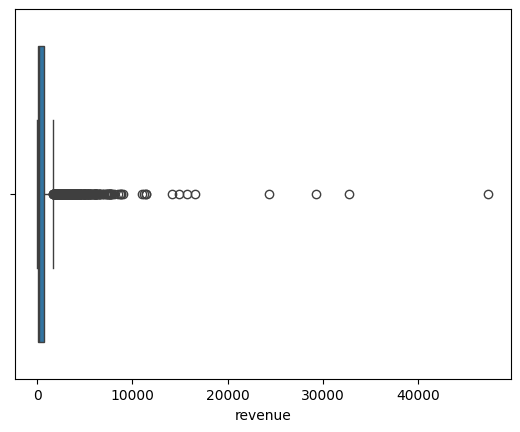

In [130]:
#проверим на аномалии столбец revenue
sns.boxplot(x=store['revenue']);

In [131]:
#проверим размер выручки по 90-му, 95-му и 99-му перцентилям
print(np.percentile(store['revenue'],  [90, 95, 99]))

[1718.   2774.   6047.12]


In [132]:
#посмотрим на заказы, в которых выручка от продажи товара превышает 10000 руб.
store.loc[store['revenue'] > 10000]

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
661,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см...",5,4874,2018,45,11,12,Tuesday,24370
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457,2018,48,11,17,Thursday,29248
1299,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,тележка багажная delta тбр-22 синий грузоподъе...,57,574,2018,51,12,16,Friday,32718
1518,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,простынь вафельная 200х180 см wellness rw180-0...,27,1755,2019,3,1,13,Tuesday,47385
1568,2019-01-22 15:00:00,6be74251-7159-4cc0-99fb-d034a17c61b0,69928,спатифиллум шопен d-12 см,45,250,2019,4,1,15,Tuesday,11250
1675,2019-02-04 06:00:00,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,мусорный контейнер hailo bigbin swing 45 0845-...,3,5512,2019,6,2,6,Monday,16536
1728,2019-02-07 09:00:00,af4d270b-c7ae-4af5-9582-4e61ff08eff0,70135,"веник сорго с деревянной ручкой с 4-мя швами, ...",20,550,2019,6,2,9,Thursday,11000
2969,2019-04-19 18:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71204,салфетка protec textil polyline 30х43 см амети...,60,191,2019,16,4,18,Friday,11460
2970,2019-04-19 18:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71205,наматрацник natures бархатный бамбук бб-н-1-2 ...,12,1183,2019,16,4,18,Friday,14196
2971,2019-04-19 19:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,одеяло wellness t142 белое темостеганое 140х20...,10,1568,2019,16,4,19,Friday,15680


In [133]:
#удалим заказы с выручкой от продажи товара от 10000 из выборки
store = store.loc[store['revenue'] <= 10000]

#проверим результат
store.loc[store['revenue'] > 10000]

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue


    Нашли 12 заказов, выручка в которых значительно превышает 99 перцентиль (6047.12 руб), отнеся эти заказы к аномалии, удалили их из датасета, чтобы уменьшить влияние выбросов на результаты последующего анализа.
    Судя по количеству товара в заказах, некоторые из них также можно было бы отнести к оптовым (заказы с кол-м товара от 10 до 64 единиц).

In [134]:
#посмотрим на заказы, которые были совершены более, чем одним покупателем
order_id = store.groupby('order_id')['customer_id'].nunique()
multi_customer_orders = order_id[order_id > 1].sort_values(ascending=False)
multi_customer_orders

order_id
72845    4
69485    3
71480    3
14872    2
70946    2
72790    2
72778    2
72188    2
71663    2
71648    2
71571    2
71542    2
71461    2
71226    2
71054    2
70903    2
68785    2
70808    2
70726    2
70631    2
70542    2
70114    2
69833    2
69531    2
69410    2
69345    2
69310    2
69283    2
72950    2
Name: customer_id, dtype: int64

In [135]:
# удалим эти заказы из датасета
store = store[~store['order_id'].isin(multi_customer_orders.index)]

#проверим, что количество уникальных покупателей для каждого заказа теперь равно 1
store.groupby('order_id')['customer_id'].nunique()

order_id
12624    1
13547    1
14480    1
14481    1
14482    1
        ..
73155    1
73156    1
73158    1
73162    1
73164    1
Name: customer_id, Length: 2736, dtype: int64

Нашли 29 заказов, с одним идентификатором заказа, но несколькими покупателями, удалили их. Один и тот же номер заказа мог быть зафиксирован у нескольких покупателей в результате ошибки в работе системы или технической неисправности.

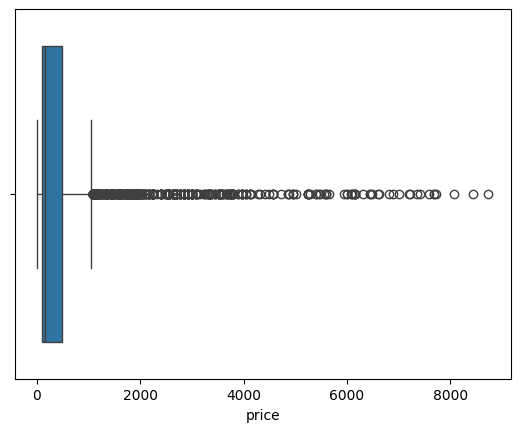

In [136]:
#проверим на аномалии столбец price
sns.boxplot(x=store["price"]);

In [137]:
#проверим размер выручки по 90-му, 95-му и 99-му перцентилям
print(np.percentile(store['price'],  [90, 95, 99]))

[1424. 2174. 4949.]


90 перцентиль равен 1424 руб. за товар т.е. 90% всех цен на товары ниже или равны 1424 руб., а только 10% цен на товары выше этого значения. Аналогично с 95 перцентилем равным 2172 руб. за товар, который говорит о том, что только 5% цен на товары выше 2172 руб., а 95% цен на товары ниже или равны этому значению. 99 перцентиль равен 4949  руб. за товар и лишь 1% цен на товары выше этого значения, а 99% цен на товары ниже или равны этому значению. Это также может указывать на то, что товары, стоящие выше этой цены, являются довольно редкими или эксклюзивными.

Смущают цены на товары свыше 8000 тыс руб, чтобы установить, является ли стоимость 8000+ выбросом, проведем доп. анализ, используя правило трех сигм.

In [138]:
#посчитаем среднее значение и стандартное отклонение
mean = np.mean(store['price'])
std = np.std(store['price'])

#определим границы выбросов
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

#найдем значения цен, выходящие за границы выбросов
outliers = store[(store['price'] < lower_bound) | (store['price'] > upper_bound)]

#посмотрим на заказы с высокой стоимостью
outliers

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,2018,40,10,21,Monday,3299
51,2018-10-02 15:00:00,494a90f5-2198-4212-8fc9-e3e22ad7afd9,68505,ерш для туалета с подставкой malibu фарфор 47х...,1,3524,2018,40,10,15,Tuesday,3524
98,2018-10-04 17:00:00,d1a13243-9111-454f-848c-dcce0958528c,68529,сумка-тележка хозяйственная andersen scala sho...,1,5024,2018,40,10,17,Thursday,5024
99,2018-10-04 17:00:00,d1a13243-9111-454f-848c-dcce0958528c,68529,сумка-тележка хозяйственная rolser jet cuadro ...,1,3734,2018,40,10,17,Thursday,3734
121,2018-10-07 07:00:00,f37fa8c2-24a0-451a-8306-39d397e7c4b2,68554,стремянка алюминиевая hailo 4302-301 livingste...,1,4949,2018,40,10,7,Sunday,4949
...,...,...,...,...,...,...,...,...,...,...,...,...
6626,2019-10-16 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,72986,сумка-тележка хозяйственная rolser mnb012 azul...,1,6600,2019,42,10,11,Wednesday,6600
6629,2019-10-16 15:00:00,d5584388-ffbe-42fd-a746-a98828ec919f,72992,стремянка 7 ступенчатая hailo 8040-707 xxl 13 ...,1,7724,2019,42,10,15,Wednesday,7724
6659,2019-10-20 19:00:00,c821b791-ce6a-4be6-849c-777b0943bd79,73038,"полки qwerty пекин белый/чёрный 95х17,5х16 см ...",1,4124,2019,42,10,19,Sunday,4124
6686,2019-10-23 15:00:00,6cfdad48-10fd-443b-bc67-93078c646779,73077,урна уличная стальная юпитер 02.012.0 38х38х60 см,1,6899,2019,43,10,15,Wednesday,6899


Проверив некоторые позиции товаров в интернете, изучив бегло список, решено было не трогать эти заказы т.к. эти высокие цены оправданы, на них есть спрос, и эти цены схожи с конкурентными.

In [139]:
print('Доля удалённых значений после чистки: {:.0f}'.format(1973/6737*100),'%')

Доля удалённых значений после чистки: 29 %


In [140]:
#проверим сводную информацию после преобразований
store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4764 entries, 0 to 6735
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4764 non-null   datetime64[ns]
 1   customer_id  4764 non-null   object        
 2   order_id     4764 non-null   int64         
 3   product      4764 non-null   object        
 4   quantity     4764 non-null   int64         
 5   price        4764 non-null   int64         
 6   year         4764 non-null   int32         
 7   week         4764 non-null   UInt32        
 8   month        4764 non-null   int32         
 9   hour         4764 non-null   int32         
 10  day_of_week  4764 non-null   object        
 11  revenue      4764 non-null   int64         
dtypes: UInt32(1), datetime64[ns](1), int32(3), int64(4), object(3)
memory usage: 414.1+ KB


In [141]:
#посмотрим описательную статистику каждого столбца в orders
store.describe(include='all')

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue
count,4764,4764,4764.00,4764,4764.00,4764.00,4764.00,4764.00,4764.00,4764.00,4764,4764.00
unique,NaN,2380,NaN,2319,NaN,NaN,NaN,<NA>,NaN,NaN,7,NaN
top,NaN,c971fb21-d54c-4134-938f-16b62ee86d3b,NaN,пеларгония розебудная red pandora укорененный ...,NaN,NaN,NaN,<NA>,NaN,NaN,Monday,NaN
freq,NaN,143,NaN,64,NaN,NaN,NaN,<NA>,NaN,NaN,839,NaN
mean,2019-03-31 09:23:21.007556608,NaN,47927.32,NaN,2.21,511.32,2018.75,26.63,6.52,13.94,NaN,644.19
min,2018-10-01 00:00:00,NaN,12624.00,NaN,1.00,9.00,2018.00,1.00,1.00,0.00,NaN,9.00
25%,2018-12-27 18:15:00,NaN,14770.00,NaN,1.00,90.00,2018.00,16.00,4.00,11.00,NaN,120.00
50%,2019-04-14 14:00:00,NaN,68844.00,NaN,1.00,150.00,2019.00,23.00,6.00,14.00,NaN,190.00
75%,2019-06-03 15:00:00,NaN,70793.25,NaN,1.00,488.00,2019.00,41.00,10.00,17.00,NaN,734.00
max,2019-10-31 14:00:00,NaN,73164.00,NaN,100.00,8737.00,2019.00,52.00,12.00,23.00,NaN,9010.00


## Предварительные выводы

1. Наименования товаров привели к нижнему регистру;  
2. Преобразовали тип данных  и добавили дополнительные столбцы с временными периодами и расчитанной выручкой от заказа;  
3. Определили, что данные в датасете предоставлены за 13 месяцев, с 2018-10-01 по 2019-10-31;  
4. Удалили 1886 неявных дубликатов, с сохранением первого зафиксированного заказа. Потеря данных составила 28%, что очень много, однако проявляя осторожность в данном вопросе, мы смогли сохранить как можно больше данных, обеспечив при этом их чистоту, согласованность и актуальность для анализа. Оставлять эти дубликаты было не уместно т.к. они могут сильно исказить результаты исследования. Дубликаты могли возникнуть из-за ошибки при выгрузке из БД, либо из-за проблемы в системе, фиксирующей продажу товаров (т.е. собраны данные, которые не полностью отображают бизнес-процесс, или сбор данных был неправильно организован) т.к. попадаются дубликаты где 1 заказ, может задублироваться до 4 раз с разницей в несколько часов, что больше похоже на этапы обработки заказа (оплата товара, сборка, отправка и т.п.);  
5. Проверили выбросы по количеству товара в заказе, удалив оптовые заказы, в которых количество товара превышало 100 единиц;    
6. Проверили выбросы по выручке от заказа, удалив заказы, в которых выручка от продажи товара превышала 10000 руб;  
7. Удалили 29 заказов, с одним идентификатором, которые были совершены более, чем одним покупателем;  
8. Дополнительно проверили выбросы по price, но в итоге, ничего по ним не удаляли;  
9. После всех проведенных манипуляций, мы удалили 29% данных, оставив 4764 строки;  
10. По описательной статистике также произошли некоторые изменения:
- больше всего заказов было совершено 2019-04-27 16:00:00 - 51 заказ;  
- больше всего заказов совершил клиент с id - c971fb21-d54c-4134-938f-16b62ee86d3b - 143 заказа;  
- часто заказываемый товар - пеларгония розебудная red pandora укорененный черенок	- приобретали 64 раза;  
- больше всего заказов зафиксировано в понедельник.  

Таким образом, мы преобразовали и подготовили данные для дальнейшего решения поставленных задач.

# Исследовательский анализ данных

## Выделим категории товаров

`Посмотрим на все объекты с наименованием товаров списком`

In [142]:
df = store['product'].tolist()
#print("\n".join(map(str, df)))

`Сгенерируем список, который будет включать в себя первое слово из каждой строки списка df`

In [143]:
word = [re.findall(r'\w+', x)[0] for x in df]
unique_words = list(set(word))
print(unique_words)

['емкость', 'тюльпан', 'томат', 'сумка', 'отбеливатель', 'измельчитель', 'ваза', 'шприц', 'подрукавник', 'совок', 'ведро', 'сменная', 'корзинка', 'одеяло', 'фатсия', 'пеперомия', 'вербейник', 'незабудка', 'котел', 'зубная', 'ролик', 'мерный', 'огурец', 'муляж', 'скребок', 'сельдерей', 'сверло', 'чайная', 'веник', 'морковь', 'тряпкодержатель', 'лантана', 'ель', 'ёрш', 'тыква', 'кувшин', 'складной', 'цветок', 'термокружка', 'стеклянная', 'овощечистка', 'этажерка', 'буддлея', 'циперус', 'стиральный', 'комплект', 'губка', 'универсальный', 'салфетница', 'весы', 'тортница', 'солидаго', 'гиностемма', 'столовый', 'суккулент', 'гипсофила', 'скатерть', 'защитная', 'примула', 'полотенце', 'защитный', 'бузульник', 'монарда', 'паста', 'годеция', 'колокольчик', 'фаленопсис', 'барвинок', 'рассада', 'тарелка', 'антуриум', 'терка', 'нефролепис', 'стяжки', 'пуансеттия', 'синнингия', 'лен', 'амариллис', 'лобелия', 'цитрофортунелла', 'пуансетия', 'измерительный', 'корзина', 'цинния', 'фиксатор', 'аптения'

`Сформируем списки слов, по которым будем присваивать категории`

In [144]:
растения = ['рассад', 'роза', 'растение','пеларгон','диффенбахия', 'помидор', 'петуния','горшке','бакопа','однолетн','кассете','калибрахоа', 'петрушка', 'кашпо',
'лобелия', 'фуксия', 'цветк', 'сковород', 'смесь', 'земляника','клубника', 'ель', 'упаков', 'аквилегия','эхинацея','вероника','колосковая','хоста','астра','аквилегия','укроп', 'd-12','d-', 'камнеломка', 'примула','вербейник', 'котовник', 'колокольчик', 'цикламен', 'барвинок', 'дыня', 'овсянница','папоротник', 'кипарис', 'бегония', 'осина', 'рассада', 'пеларгония', 'кабачок', 'зелень', 'огурец', 'томат', 'петуния', 'помидор', 'крупноцветковый', 'цветок', 'капуста', 'тагетис', 'однолетний', 'арбуз', 'вербена', 'герань','тыква', 'базилик', 'лобелия', 'клубника', 'флокс', 'гунни', 'циперус', 'груша', 'зумула', 'фиалка', 'баклажан', 'плющелистный', 'тюльпановидный', 'персик', 'тимьян', 'виола', 'виноград', 'пуансеттия', 'черенок', 'розебудный', 'комнатный', 'калибрахоа', 'бархатцы', 'космея', 'морков', 'настурц', 'алисс', 'гвоздика', 'годеци', 'календу', 'кореопс', 'лапчат', 'цинерар', 'эшшольц', 'горох', 'тюльпан', 'георгин', 'смолевк', 'цинни', 'котовик', 'ясколка', 'платикод', 'энотер', 'настурци', 'пиретрум', 'кореопс', 'монард', 'рудбеки', 'седум', 'бузульник', 'солидаг', 'физостег', 'бадан', 'лен небесная', 'лаватер', 'анемон', 'салат']
для_кухни = ['разделочн','чайн','блюдо','сковород','картофелемял', 'орехокол', 'скалк', 'венчик', 'торт','вилка','тарелк', 'ложка','фужер','посуд', 'кувшин', 'противень','соковыжим','лопатка', 'стакан','салатн','нож', 'бокал','чай','столов','банка','круж', 'толкушка','терка', 'варка','масл', 'чистка', 'салфет', 'кастрюл', 'webber','сахар', 'котел','wilmax', 'половник','скатерть', 'кипят','дозатор','зажиг','губка спираль','миска', 'термос', 'хлебница','кухон', 'кухн', 'бульон', 'выпеч', 'пресс', 'блюд', 'тарелка', 'набор', 'салатник', 'обеденный', 'десертный', 'набор']
интерьер = ['корзина', 'кашпо', 'муляж', 'ключниц', 'скоба', 'основание', 'обувниц', 'ваза','коврик', 'домашний', 'искусственный', 'штор', 'вешалка', 'декоративная', 'комод','покрывало', 'одеяло', 'фоторамка','этажерка', 'полки', 'кухонное','подарочный', 'наматрацник', 'стеллаж', 'складной', 'ковер', 'ковёр', 'светил', 'одеял', 'простын', 'подуш', 'плед', 'матрас', 'покрывало', 'спальн', 'наволочка', 'искусственн']
ванная = ['ванн', 'полотен', 'ёрш', 'ерш', 'зуб', 'увлажняющая', 'вантуз', 'халат', 'мыл']
хоз_товары = ['покрытие', 'перчат', 'почтов', 'ролик', 'шил', 'подголовн', 'капронов', 'скребок', 'антинакипин', 'шпагат', 'шнур', 'решетка', 'чехол', 'штангенциркуль', 'фиксатор', 'насадка', 'ткан', 'термометр', 'весы', 'тряп', 'швабр', 'совок', 'гладил', 'глажен', 'прищеп', 'налет','антижир', 'пылесос', 'крем', 'стир', 'щетка', 'сушилк', 'веник', 'подрукавник', 'совком', 'для чистки', 'стирки', 'мыть', 'средство','мойк', 'полки', 'вешал', 'плечики', 'стеллаж', 'хранен', 'крючок', "этажерка", 'комод','подставка', 'полка', 'кофр', 'лоток', 'корыт', 'таз', 'контейнер', 'бак ', 'мусор', 'ведр', 'урна', 'корзин', 'бидон', 'ковш','коробка', 'емкость', 'сумк', 'тележ']
инструменты = ['инструмент', 'сверел', 'сверло', 'напильник', 'стремянк', 'стяжк', 'шпингалет', 
              'сварка', 'крепеж', 'пружин', 'петл', 'линейк', 'гои']
бытовая_техника = ['миксер', 'электрич', 'весы', 'фен', 'электроштопор', 'пылесос', 'утюг', 'кипятильник', 'соковыжималка', 'кипятильник']


`Напишем функцию, которая присваивает категорию товарам на основе того, присутствуют ли в их названиях определенные слова из list_of_words`

In [145]:
#создадим новый столбец category
store['category'] = 0
def categoryzer(list_of_words, category):
  join = '|'.join(list_of_words) #объединим все слова в списке в единую строку с разделителем
  index = store[store['product'].str.lower().str.contains(join)].index.to_list()
  #перебор индексов и присваивание категории для каждой соответствующей строки  
  for i in index:
    store.loc[i, 'category'] = category
  return store #возвращение измененного датафрейма


In [146]:
# присвоим категории товарам в нашем датасете
categoryzer(растения, 'растения')
categoryzer(для_кухни, 'для_кухни')
categoryzer(интерьер, 'интерьер')
categoryzer(ванная, 'ванная')
categoryzer(хоз_товары, 'хоз_товары')
categoryzer(инструменты, 'инструменты')
categoryzer(бытовая_техника, 'бытовая_техника')
store['category'] = store['category'].apply(lambda x: 'другое' if (x==0) else x)

In [147]:
#сгруппируем датафрейм по столбцу категория
categoryzer_df = store.groupby('category').agg({'product':'count'}).reset_index()
#изменим названия столбцов
categoryzer_df.columns = ['category', 'rows']
#посчитаем долю товаров в каждой категории и округлим результат до 3х знаков после запятой
categoryzer_df['percent_of_product'] = (categoryzer_df['rows'] / len(store)).round(3)
#заменим категорию значений не попавших в какую-либо категорию, на без_категории
categoryzer_df['category'] = categoryzer_df['category'].replace(0, 'Без категории')
#отсортируем датафрейм в порядке убывания по столбцу percent_of_product
categoryzer_df = categoryzer_df.sort_values(by='percent_of_product', ascending = False)
#отформатируем столбец percent_of_product в % с 2-мя знаками после запятой
categoryzer_df['percent_of_product'] = categoryzer_df['percent_of_product'].map('{:.2%}'.format)

print(categoryzer_df)
print('\nСтрок без категории: {}'.format(len(store[store['category']==0])))

          category  rows percent_of_product
5         растения  2178             45.70%
6       хоз_товары  1335             28.00%
2        для_кухни   558             11.70%
4         интерьер   425              8.90%
1           ванная   163              3.40%
3      инструменты    76              1.60%
0  бытовая_техника    29              0.60%

Строк без категории: 0


In [148]:
#проверим полученный результат по категориям
#(store.loc[store['category'] == 'растения']).head(5)
#(store.loc[store['category'] == 'хоз_товары']).head(5)
#(store.loc[store['category'] == 'для_кухни']).head(5)
#(store.loc[store['category'] == 'интерьер']).head(5)
#(store.loc[store['category'] == 'ванная']).head(5)
#(store.loc[store['category'] == 'инструменты']).head(5)
(store.loc[store['category'] == 'бытовая_техника']).head(5)
#store.loc[store['category'] == 'другое']

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue,category
243,2018-10-14 05:00:00,88433cc8-53a6-4f7b-8fee-111496371277,68639,миксер delta lux dl-5068 серо-голубой 400 вт 4...,1,1049,2018,41,10,5,Sunday,1049,бытовая_техника
539,2018-10-30 21:00:00,7c769d6c-869c-4200-b3a6-c33ef2d7723f,68805,утюг электрический с керамическим покрытием de...,1,1199,2018,44,10,21,Tuesday,1199,бытовая_техника
824,2018-11-16 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69023,чайник электрический пластиковый василиса t7-1...,1,539,2018,46,11,11,Friday,539,бытовая_техника
888,2018-11-20 20:00:00,5dc4e41f-a869-4fac-ae05-f448acdb548d,69066,фен дорожный delta dl-0904 бордовый с черным 2...,1,592,2018,47,11,20,Tuesday,592,бытовая_техника
889,2018-11-20 20:00:00,5dc4e41f-a869-4fac-ae05-f448acdb548d,69066,чайник электрический аксинья кс-1003 корпус из...,1,1049,2018,47,11,20,Tuesday,1049,бытовая_техника


## Проанализируем распределение категорий товаров

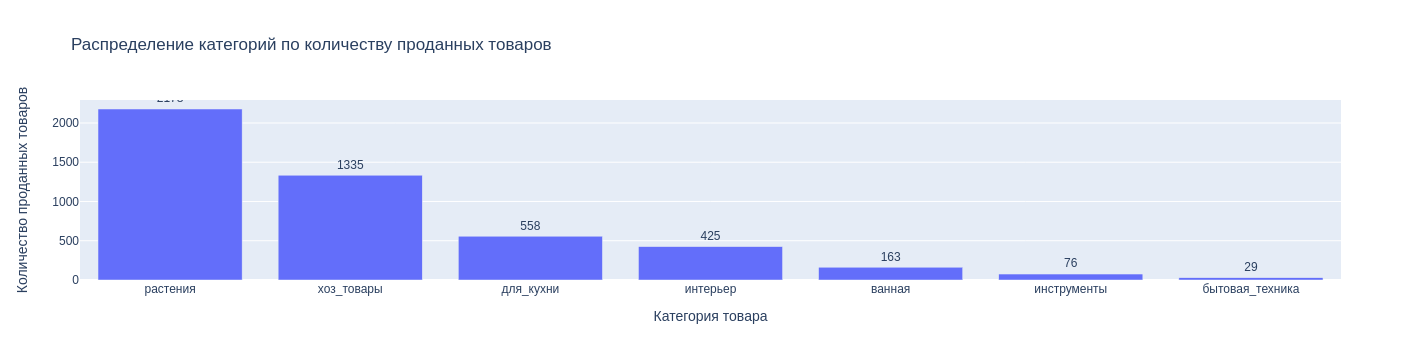

In [149]:
fig = px.bar(categoryzer_df, x='category', y='rows',
             labels={'category': 'Категория товара', 'rows': 'Количество проданных товаров'},
             title='Распределение категорий по количеству проданных товаров')
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()

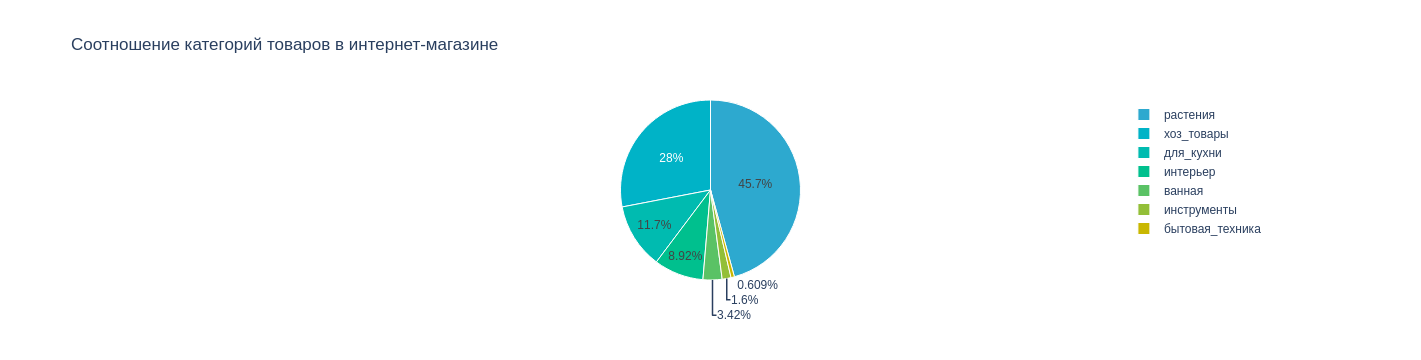

In [150]:
#посмотрим на соотношение категорий товаров
fig = go.Figure(
    data=[go.Pie(labels=categoryzer_df["category"], values=categoryzer_df["rows"])]
)
fig.update_traces(marker=dict(colors=['#2da9cf', '#00b3c7', '#00bbb0', '#00c08e', '#5ac265', '#93bf38', '#c9b701'], line=dict(color='#ffffff', width=1)))
fig.update_layout(title="Соотношение категорий товаров в интернет-магазине")
fig.show()

Из представленных данных о количестве проданных товаров и их распределении по категориям можно сделать вывод, что:
   -  категория "растения" является наиболее популярной среди покупателей, с общим количеством проданного в 2178 единиц и долей в 45,7%
   - за ней следует категория "хозяйственные товары" с общим количеством проданного товара - 1335 единиц  и долей в 28%
   - товаров для кухни было продано 558 единиц с долей в 11,7%
   - категория интерьер с общим количеством проданного в 425 единиц и долей в 8,90%  
    Остальные категории, такие как "ванная", "инструменты" и "бытовая техника", имеют значительно меньшее количество проданных единиц товара и долю товаров в категории, что может указывать на более узкий круг потребностей у покупателей в этих областях.
    В целом, количество проданного товара категорий растения и хоз_товары существенно превышает количество проданного товара менее популярных категорий, что может быть полезно для принятия решений о маркетинге и запасах.

## Проанализируем средний чек по категориям

In [151]:
order_group = store.groupby('order_id').agg({'customer_id':'first',
                                            'product':'count',
                                            'price':['mean','sum'],
                                            'category': lambda x:x.value_counts().index[0],
                                            'date':'first'}).reset_index()
order_group.columns = ['order_id', 'customer_id', 'product_count', 'mean_price', 'sum_price', 'category' ,'date']
avg_check = order_group.groupby('category').agg({'product_count':'sum','sum_price':'sum'})
avg_check['mean'] = avg_check['sum_price']/avg_check['product_count']
avg_check = avg_check.sort_values(by = 'mean', ascending = False).reset_index()
avg_check

,category,product_count,sum_price,mean
0,инструменты,71,116286,1637.83
1,хоз_товары,1317,1517966,1152.59
2,ванная,151,138122,914.72
3,бытовая_техника,32,26066,814.56
4,интерьер,412,143898,349.27
5,для_кухни,519,150468,289.92
6,растения,2262,343143,151.70


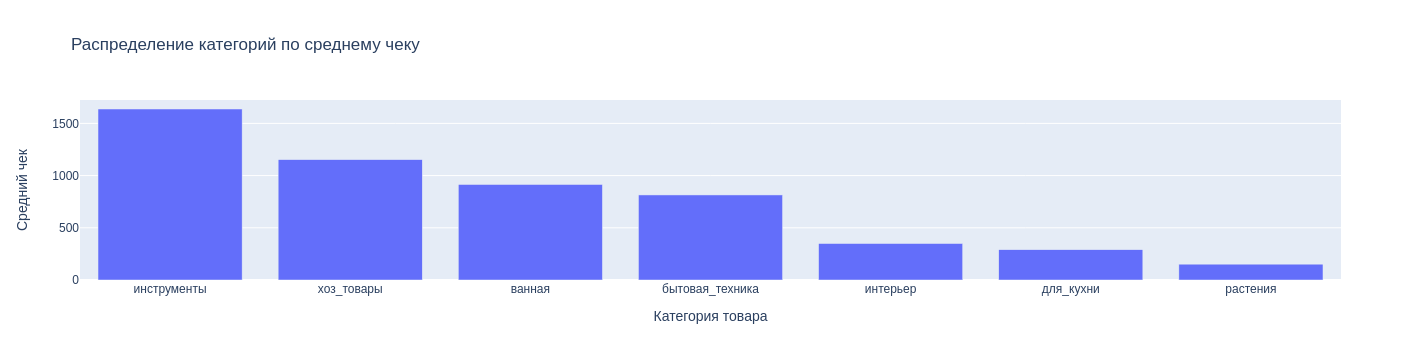

In [152]:
fig = px.bar(avg_check, x='category', y='mean', 
             labels={'category': 'Категория товара', 'mean': 'Средний чек'},
             title='Распределение категорий по среднему чеку')
fig.show()

<div style="border:solid #2da9cf 2px; padding: 20px">
    
    Можно сделать вывод, что категория "инструменты" имеет наибольший средний чек в размере 1637.83 руб., что может указывать на то, что эти товары обычно являются более дорогими. За ней следует категория "хоз_товары" со средним чеком в размере 1152.59 руб.
    Другие категории, такие как "ванная" и "бытовая техника", имеют средние чеки в размере 914.71 руб. и 814.56 руб. соответственно. Категории "интерьер" и "для кухни" имеют более низкие средние чеки, равные 349.26 руб. и 289.91 руб. соответственно. Категория "растения" имеет самый низкий средний чек среди всех категорий, равный 151.69 руб. В целом, средний чек в каждой категории может указывать на ценовой диапазон товаров и предпочтения покупателей в разных категориях товаров.

## Проанализируем общую выручку по категориям

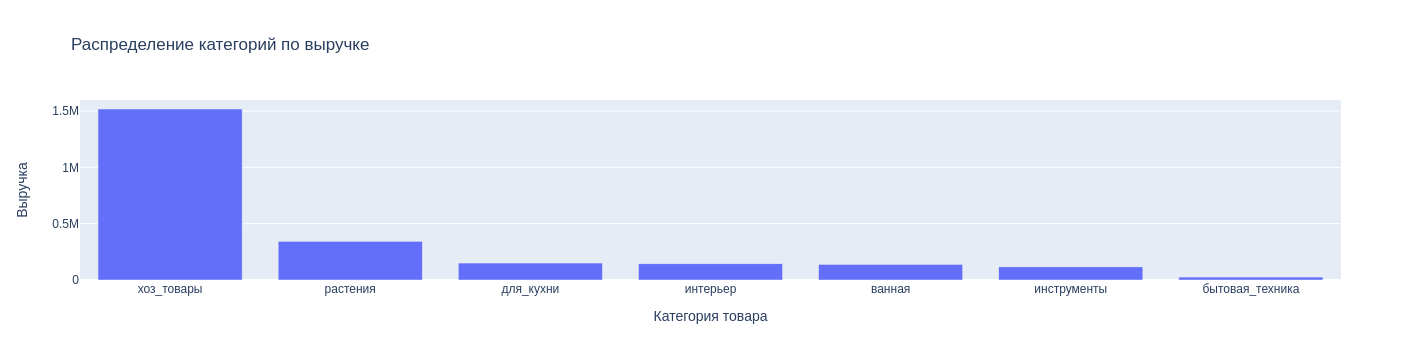

In [153]:
fig = px.bar(avg_check, x='category', y='sum_price', 
             labels={'category': 'Категория товара', 'sum_price': 'Выручка'},
             title='Распределение категорий по выручке')
fig.update_xaxes(categoryorder='total descending')
fig.show()

<div style="border:solid #2da9cf 2px; padding: 20px">

    Категория "хозяйственные товары" является наиболее прибыльной, имея общую выручку в размере 1517966 руб. и занимая второе место по количеству проданных товаров. Категории "растения" и "для кухни" также имеют высокие общие выручки, равные 343143 руб. и 150468 руб. соответственно.
    Категория "инструменты" несмотря на то, что занимает первое место по среднему чеку среди всех категорий, имеет общую выручку в размере 116286 руб. и занимает шестую позицию по общей выручке.  
    Остальные категории имеют низкие выручки, но среди них аутсайдером является категория "бытовая техника", всего 26066 руб.

## Проанализируем выручку по категориям с разбивкой по месяцам

In [154]:
#изменим номера месяца для октября 2019 года на 13
store.loc[(store['year'] == 2019) & (store['month'] == 10), 'month'] = 13

#преобразуем номера месяца в название месяца и год
store['month_year'] = store['date'].dt.to_period(freq='M')

#отфильтруем данные по периоду
start_date = pd.Timestamp('2018-10-01 00:00:00')
end_date = pd.Timestamp('2019-10-31 23:59:59')
store_filtered = store.loc[(store['date'] >= start_date) & (store['date'] <= end_date)]

#сгруппируем данные по месяцам и категориям
rev_cat_season = store_filtered.groupby(['month_year', 'category']).agg({
    'customer_id': 'nunique',
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()

print(rev_cat_season)


   month_year         category  customer_id  quantity  revenue
0     2018-10  бытовая_техника            2         2     2248
1     2018-10           ванная           10        20    17090
2     2018-10        для_кухни           33       113    28984
3     2018-10      инструменты           12       138    22624
4     2018-10         интерьер           25       238    35959
..        ...              ...          ...       ...      ...
84    2019-10        для_кухни           10        34     3983
85    2019-10      инструменты           10       230    25611
86    2019-10         интерьер           24       210    18786
87    2019-10         растения           48        90    16645
88    2019-10       хоз_товары           71       154   126048

[89 rows x 5 columns]


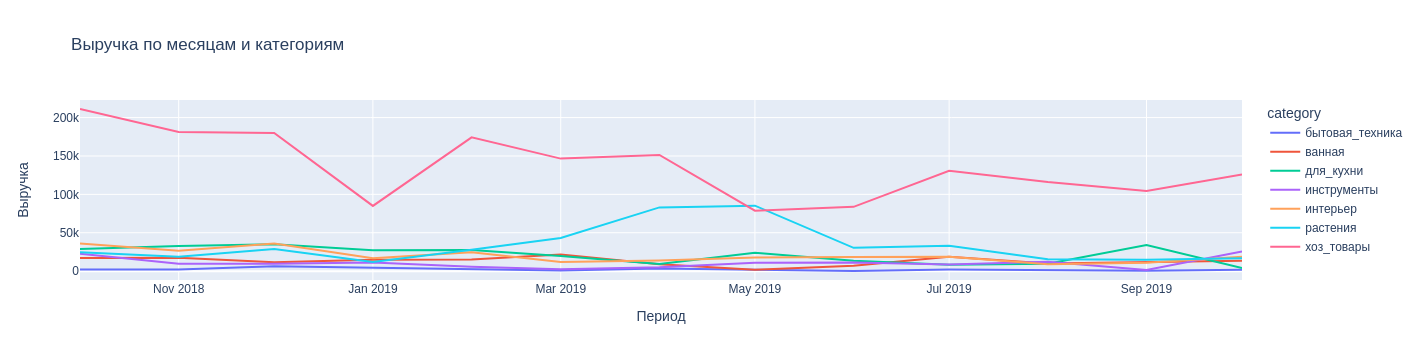

In [155]:
#преобразуем столбец с месяцем и годом для построения графика
rev_cat_season['month_year'] = rev_cat_season['month_year'].astype(str)

fig = px.line(rev_cat_season, x='month_year', y='revenue',
              color='category',
              title='Выручка по месяцам и категориям',
              labels={"month_year": "Период",
                      "revenue": "Выручка"}
)

fig.update_xaxes(tickmode='array', ticktext=rev_cat_season['month_year'].astype(str))

fig.show()


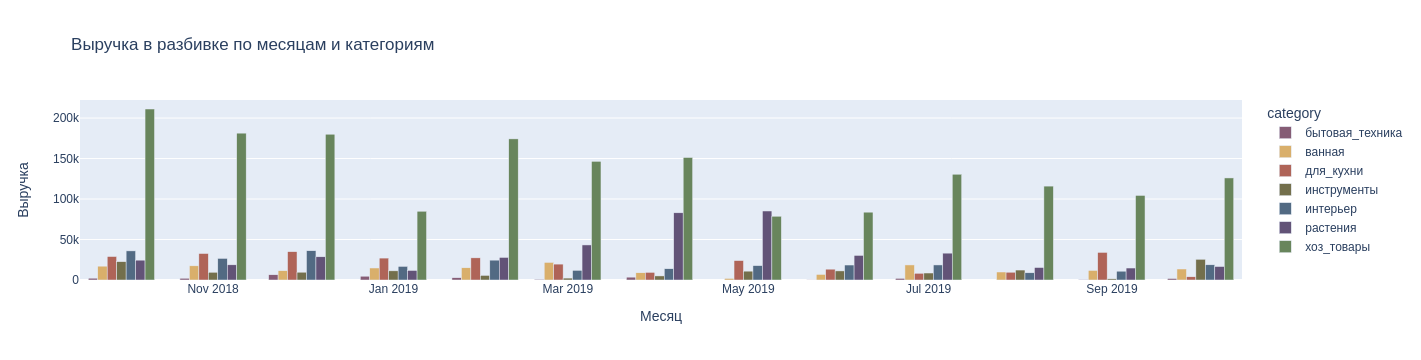

In [156]:
fig = px.bar(
    rev_cat_season, 
    x='month_year', 
    y='revenue', 
    color='category', 
    barmode='group', 
    title='Выручка в разбивке по месяцам и категориям',
    color_discrete_sequence=px.colors.qualitative.Antique,
    labels={"month_year": "Месяц",
            "revenue": "Выручка"}
)
fig.show()


<div style="border:solid #2da9cf 2px; padding: 20px">
    
	1. Судя по графикам, самой прибыльной категорией товаров является хозяйственные товары, она ежемесячно приносит хорошую выручку до 204324 руб., однако она снижается в январе, мае и июне и держится в пределах ~80 тыс. руб.
	2. Также можно отметить ярко выраженную сезонность в повышенной выручке от продажи растений в апреле и мае, в пределах ~82 тыс. руб.
	3. Далее следуют категории товаров для кухни и товары для интерьера, обе категории достигли пика по выручке в период октябрь-декабрь 2018, с выручкой в пределах 35028 руб. и 36314 руб. соответственно. Самая низкая выручка была получена по обеим категориям в апреле и августе 2019.
	4. Выручка по товарам для ванной в основном колеблется в диапазоне 10-15 тыс. руб, пиковый месяц продаж был март 2019 года, однако дальше была большая просадка по выручке, с апреля по июнь 2019 падение выручки достигало 2080 руб.
	5. Категория товаров инструменты, приносит наибольшую прибыль в октябре, свыше 20 тыс. руб., что можно увидеть на графиках за 2018 и 2019 годы. Хуже всего дела обстоят с продажами в марте, апреле и сентябре 2019. Просадка по выручке достигала 1462 руб.
	6. Самой низкоприбыльной категорией оказалась бытовая техника, возможно это из-за специфики магазина и товаров в этой категории. Пик по прибыли был достигнут в декабре 2018, а самый большой спад в 2019 в марте, мае и сентябре, с наименьшей выручкой в 164 руб.
    
    

## Проанализируем выручку по категориям с разбивкой по дням недели

In [157]:
#сгруппируем данные по дням недели и категориям
rev_sum_1 = store.groupby(['day_of_week', 'category']).agg({
    'customer_id': 'count',
    'order_id': 'count',
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()
rev_sum_1 = rev_sum_1.sort_values(['revenue'], ascending=[False])

rev_sum_1

,day_of_week,category,customer_id,order_id,quantity,revenue
41,Tuesday,хоз_товары,224,224,712,312298
48,Wednesday,хоз_товары,207,207,476,303014
6,Friday,хоз_товары,188,188,393,271028
13,Monday,хоз_товары,232,232,733,270919
34,Thursday,хоз_товары,186,186,433,253288
27,Sunday,хоз_товары,160,160,223,201162
20,Saturday,хоз_товары,138,138,185,157731
12,Monday,растения,413,413,728,86595
33,Thursday,растения,364,364,516,73248
40,Tuesday,растения,378,378,628,72400


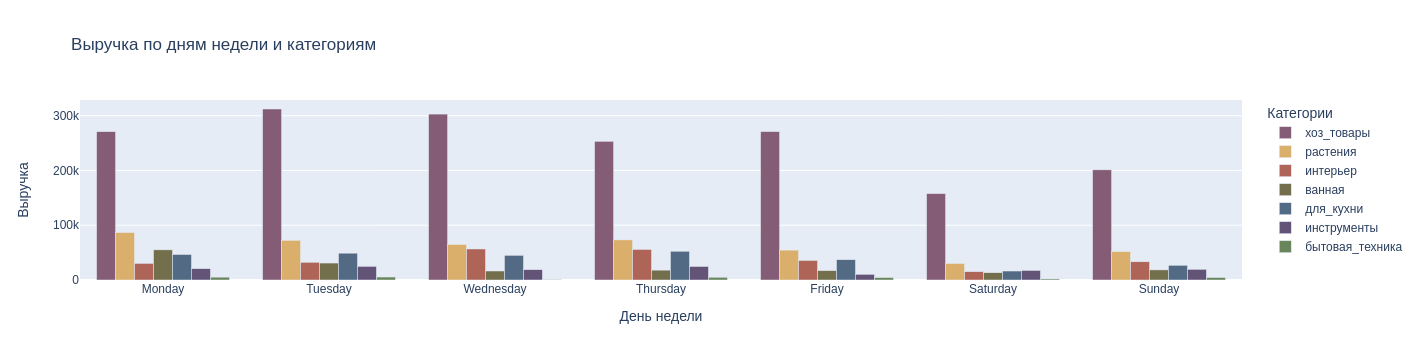

In [158]:
fig = px.bar(
    rev_sum_1, 
    x='day_of_week', 
    y='revenue', 
    color='category', 
    barmode='group', 
    title='Выручка по дням недели и категориям',
    color_discrete_sequence=px.colors.qualitative.Antique,
    labels={"day_of_week": "День недели",
            "revenue": "Выручка",
            "category": "Категории"},
    category_orders={"day_of_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}
)
fig.show()

<div style="border:solid #2da9cf 2px; padding: 20px">
    
	Из представленных данных можно сделать вывод о том, что есть некоторая взаимосвязь между выручкой от продаж и днями недели:
	1. Высокая прибыль чаще всего была получена по понедельникам и четвергам, наименьшая прибыль получена в субботу и воскресенье.
	2. Можно сказать, что хоз товары продаются хорошо с завидной регулярностью и с общей выручкой в будни от 250 тыс. руб., чуть хуже обстоят дела с общей выручкой в выходные дни не превышая порог в 200 тыс. руб.
	3. Растения хорошую выручку приносят с понедельника по четверг, с пятницы по воскресенье наблюдается падение выручки. Скорее всего это связано с тем, что люди уже в этот период заняты работами в своих дачах, садах и огородах, поэтому к ним готовятся заранее, приобретая необходимые товар в будни.
	4. Товары для интерьера приносят наибольшую прибыль по средам и четвергам, наименьшая прибыль получена в субботу.
	5. Товары для ванной приносят наибольшую выручку лишь по понедельникам.
    6. Товары для кухни продаются хорошо с понедельника по четверг, общая прибыль в пределах ~40-50 тыс. руб в пятницу наблюдается понижение. В субботу за исследуемый период было продано товара на общую сумму 16402 руб, а в воскресенье на 26866 руб.
	7.  Инструменты самую высокую прибыль приносят по вторникам и четвергам, в пределах ~25 тыс. руб., в то время как по субботам наблюдается большой спад по прибыли, в пределах ~10 тыс. руб.
	9. Бытовая техника в целом приносит небольшую общую прибыль, хуже всего она по средам и субботам, 704 руб. и 1994 руб. соответственно.

## Проанализируем выручку по категориям с разбивкой по времени суток

In [159]:
# создаем список интервалов для разделения данных на утренние и вечерние часы
bins = [0, 6, 12, 18, 24]

# создаем список меток для интервалов
labels = ['ночь', 'утро', 'день', 'вечер']

# добавляем новый столбец "time_of_day" с метками для каждого интервала
store['time_of_day'] = pd.cut(store['hour'], bins=bins, labels=labels, include_lowest=True)

# группировка данных по категориям и времени суток, суммирование выручки
revenue_by_category_and_time = store.groupby(['category', 'time_of_day'])['revenue'].sum()

# преобразование мультииндекса в обычные столбцы
revenue_by_category_and_time = revenue_by_category_and_time.reset_index()

# сортировка по выручке для каждой категории
revenue_by_category_and_time = revenue_by_category_and_time.groupby('category').apply(lambda x: x.sort_values('revenue', ascending=False))

# вывод результатов
print(revenue_by_category_and_time)


                           category time_of_day  revenue
category                                                
бытовая_техника 1   бытовая_техника        утро     8773
                3   бытовая_техника       вечер     7853
                2   бытовая_техника        день     7642
                0   бытовая_техника        ночь     3058
ванная          6            ванная        день    71667
                5            ванная        утро    59412
                7            ванная       вечер    29454
                4            ванная        ночь     8772
для_кухни       10        для_кухни        день   124769
                9         для_кухни        утро    83745
                11        для_кухни       вечер    53545
                8         для_кухни        ночь    11488
инструменты     13      инструменты        утро    68591
                14      инструменты        день    35067
                15      инструменты       вечер    25132
                12      инструм

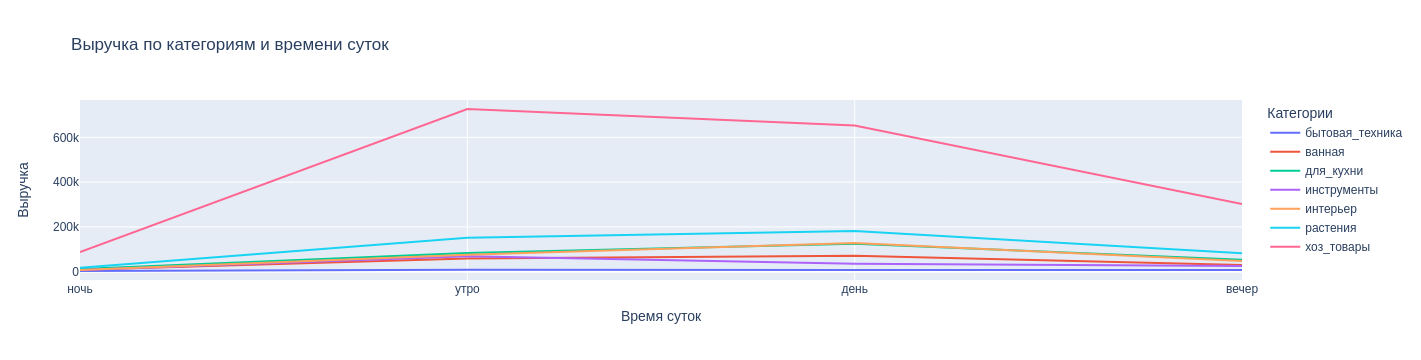

In [160]:
# создаем список интервалов для разделения данных на утренние и вечерние часы
bins = [0, 6, 12, 18, 24]

# создаем список меток для интервалов
labels = ['ночь', 'утро', 'день', 'вечер']

# добавляем новый столбец "time_of_day" с метками для каждого интервала
store['time_of_day'] = pd.cut(store['hour'], bins=bins, labels=labels, include_lowest=True)

# группировка данных по категориям и времени суток, суммирование выручки
revenue_by_category_and_time = store.groupby(['category', 'time_of_day'])['revenue'].sum()

# преобразование мультииндекса в обычные столбцы, избавляемся от задвоенных столбцов category
revenue_by_category_and_time = revenue_by_category_and_time.reset_index()

# создание графика
fig = px.line(revenue_by_category_and_time, x="time_of_day", y="revenue", color="category",
              labels={
                  "time_of_day": "Время суток",
                  "revenue": "Выручка",
                  "category": "Категории"
              },
              title="Выручка по категориям и времени суток")
fig.show()


<div style="border:solid #2da9cf 2px; padding: 20px">
    
	На основании анализа выручки интернет-магазина по продаже товаров в разрезе времени суток можно сделать следующие выводы:
	1. Бытовая техника приносит большую прибыль в утренние и дневные часы, хуже в ночные.
	2. Товары для ванной лучше продаются утром и днем, хуже вечером и ночью
	3. Товары для кухни приносят большую прибыль в дневные часы, хуже вечером и ночью
	4. Инструменты выгоднее продаются по утрам и значительно хуже в остальное время суток
	5. Товары для интерьера выгоднее продаются днем и и значительно хуже в остальное время суток
	6. Растения приносят хорошую выручку в первой половине дня, чуть лучше в дневные часы и чуть хуже в утренние, с большим снижением продаж во второй половине дня
	7. Хоз товары приносят хорошую выручку также в первой половине дня, чуть лучше в утренние часы и чуть хуже в дневные, со снижением выручки от продаж во второй половине дня

## Исследуем количество заказов с разбивкой по месяцам

In [161]:
#сгруппируем данные по месяцам и категориям
order_cat_season = store_filtered.groupby(['month_year', 'category']).agg({
    'customer_id': 'nunique',
    'quantity': 'sum',
    'order_id': 'nunique'
}).reset_index()

print(order_cat_season)

   month_year         category  customer_id  quantity  order_id
0     2018-10  бытовая_техника            2         2         2
1     2018-10           ванная           10        20        15
2     2018-10        для_кухни           33       113        35
3     2018-10      инструменты           12       138        13
4     2018-10         интерьер           25       238        28
..        ...              ...          ...       ...       ...
84    2019-10        для_кухни           10        34        10
85    2019-10      инструменты           10       230        11
86    2019-10         интерьер           24       210        24
87    2019-10         растения           48        90        55
88    2019-10       хоз_товары           71       154        86

[89 rows x 5 columns]


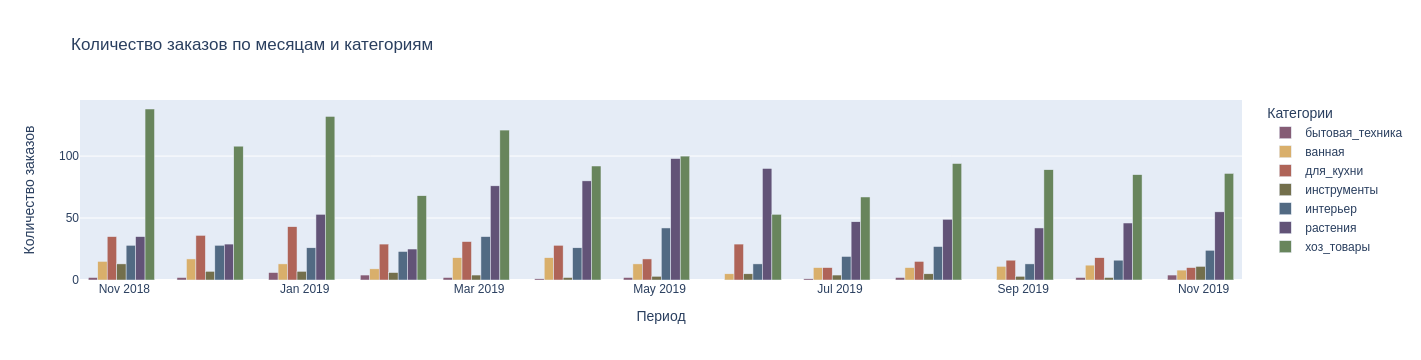

In [162]:
#преобразуем столбец month_year в тип datetime для построения графика
order_cat_season['month_year'] = order_cat_season['month_year'].apply(lambda x: x.to_timestamp('M'))

fig = px.bar(
    order_cat_season, 
    x='month_year', 
    y='order_id', 
    color='category', 
    barmode='group', 
    title='Количество заказов по месяцам и категориям',
    color_discrete_sequence=px.colors.qualitative.Antique,
    labels={"month_year": "Период",
            "order_id": "Количество заказов",
            "category": "Категории"}
)
fig.show()

<div style="border:solid #2da9cf 2px; padding: 20px">
    
	Наблюдаем следующую картину с оформленными заказами по месяцам:
	1. По бытовой технике больше всего заказов совершено в декабре (6 шт), скорее всего люди приобретали товары в качестве подарка на новый год, в мае 2019 не было заказов совсем.
	2. Товары для ванной заказывают с регулярной активностью. Больше всего заказов было зафиксировано в ноябре 2018 - 18 заказов, в феврале 2019 - 18 заказов и в марте - 17 заказов. Возможно продажи этой категории товаров связаны с такими событиями как черная пятница в ноябре, 14 и 23 февраля, а также 8 марта, т.е. распродажа и праздники. Снижение заказов наблюдается в мае.
	3. По товарам для кухни меньше всего заказов было в летний сезон, больше всего заказов зафиксировано с октября по декабрь 2018. Количество заказов в октябре 2018 (34 заказа) и октябре 2019 (11 заказов) сильно разнится.
	4. Инструменты чаще всего заказывают в октябре, эти показатели схожи в 2018 (12 заказов) и 2019 (11 заказов) годах. Меньше всего заказов зафиксировано в марте и сентябре 2019.
	5. Товары для интерьера пользовались наибольшим спросом в апреле (41 заказ) и наименьшим спросом в мае (14 заказов) и августе (13 заказов).
	6. Товарная категория растения, пользуется спросом с февраля по май, ежемесячное количество заказов было более 70. Меньше всего заказов было в ноябре и январе. В промежуточном декабре был небольшой скачок в количестве заказов, скорее всего из-за нового года, люди покупали растения в качестве подарка.
	7. По хоз товарам интересная картина, количество заказов ежемесячно то повышается, то понижается. Возможно на заказах отражается работа маркетингового отдела, который разрабатывает и внедряет акции, скидки, рекламные кампании. Меньше всего заказов зафиксировано в январе, мае и июне, в периоды праздников, выходных и отпусков.

## Исследуем количество заказов с разбивкой по дням недели

In [163]:
#сгруппируем данные по месяцам и категориям
rev_sum_2 = store.groupby(['day_of_week', 'category']).agg({
    'customer_id': 'count',
    'order_id': 'count',
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()
rev_sum_2 = rev_sum_2.sort_values(['customer_id'], ascending=[False])
rev_sum_2

,day_of_week,category,customer_id,order_id,quantity,revenue
12,Monday,растения,413,413,728,86595
40,Tuesday,растения,378,378,628,72400
33,Thursday,растения,364,364,516,73248
47,Wednesday,растения,306,306,410,64725
5,Friday,растения,278,278,416,54592
26,Sunday,растения,246,246,369,51842
13,Monday,хоз_товары,232,232,733,270919
41,Tuesday,хоз_товары,224,224,712,312298
48,Wednesday,хоз_товары,207,207,476,303014
19,Saturday,растения,193,193,261,30105


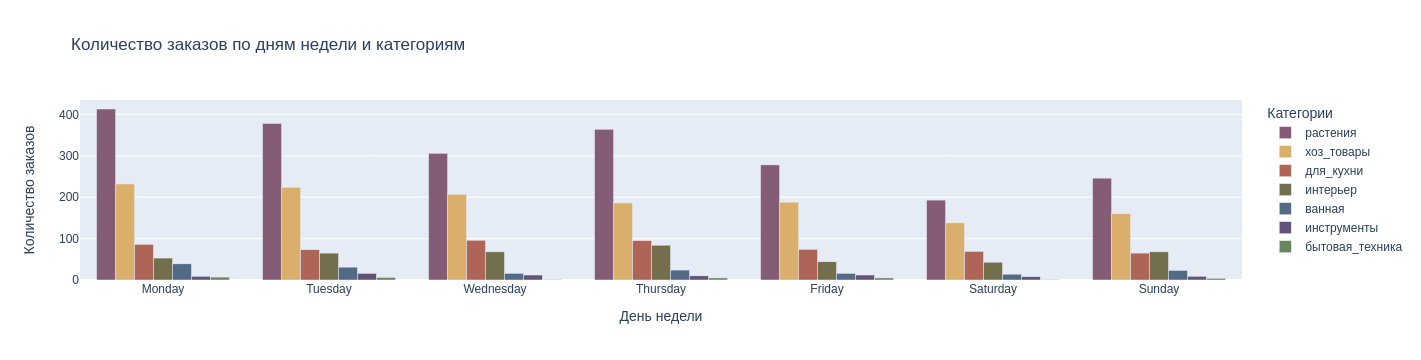

In [164]:
fig = px.bar(
    rev_sum_2, 
    x='day_of_week', 
    y='order_id', 
    color='category', 
    barmode='group', 
    title='Количество заказов по дням недели и категориям',
    color_discrete_sequence=px.colors.qualitative.Antique,
    labels={"day_of_week": "День недели",
            "order_id": "Количество заказов",
            "category": "Категории"},
    category_orders={"day_of_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}
)
fig.show()


<div style="border:solid #2da9cf 2px; padding: 20px">
    
	Из представленных данных можно сделать следующие выводы:
	1. Растения чаще заказывают в начале недели в понедельник, вторник и четверг, в выходные дни спад по заказам.
	2. Заказы по категории хоз_товары равномерно распределены по всей неделе, с небольшой просадкой в субботу и воскресенье.
	3. Товары для кухни клиенты также заказывают на регулярной основе, но немного чаще они делают это в среду и четверг.
	4. Спрос на товары для интерьера особенно высок по четвергам, в то время как в пятницу и субботу наблюдается его падение.
	5. Товары для ванной в сравнении с остальными группами не так часто заказывают, однако здесь тоже есть тенденция на повышение спроса в понедельник и вторник, а также спад в среду, пятницу и субботу.
	6. По категории инструменты больше всего было зафиксировано заказов по вторникам, в остальные дни заказы показывают небольшие колебания, но без больших просадок.
	7. Бытовой техникой клиенты не интересуются по вредам и субботам, совершая заказы в остальные дни. Больше всего заказов зафиксировано по понедельникам и вторникам  - 7 шт. и 6 шт. соответственно.

## Исследуем количество заказов с разбивкой по времени суток

In [165]:
# создаем список интервалов для разделения данных на утренние и вечерние часы
bins = [0, 6, 12, 18, 24]

# создаем список меток для интервалов
labels = ['ночь', 'утро', 'день', 'вечер']

# добавляем новый столбец "time_of_day" с метками для каждого интервала
store['time_of_day'] = pd.cut(store['hour'], bins=bins, labels=labels, include_lowest=True)

# группировка данных по категориям и времени суток, суммирование выручки
orders_by_category_and_time = store.groupby(['category', 'time_of_day'])['order_id'].count()

# преобразование мультииндекса в обычные столбцы
orders_by_category_and_time = orders_by_category_and_time.reset_index()

# сортировка по выручке для каждой категории
orders_by_category_and_time = orders_by_category_and_time.groupby('category').apply(lambda x: x.sort_values('order_id', ascending=False))

# вывод результатов
print(orders_by_category_and_time)

                           category time_of_day  order_id
category                                                 
бытовая_техника 1   бытовая_техника        утро        10
                2   бытовая_техника        день         8
                3   бытовая_техника       вечер         8
                0   бытовая_техника        ночь         3
ванная          6            ванная        день        58
                5            ванная        утро        55
                7            ванная       вечер        42
                4            ванная        ночь         8
для_кухни       10        для_кухни        день       270
                9         для_кухни        утро       137
                11        для_кухни       вечер       132
                8         для_кухни        ночь        19
инструменты     13      инструменты        утро        33
                15      инструменты       вечер        21
                14      инструменты        день        19
              

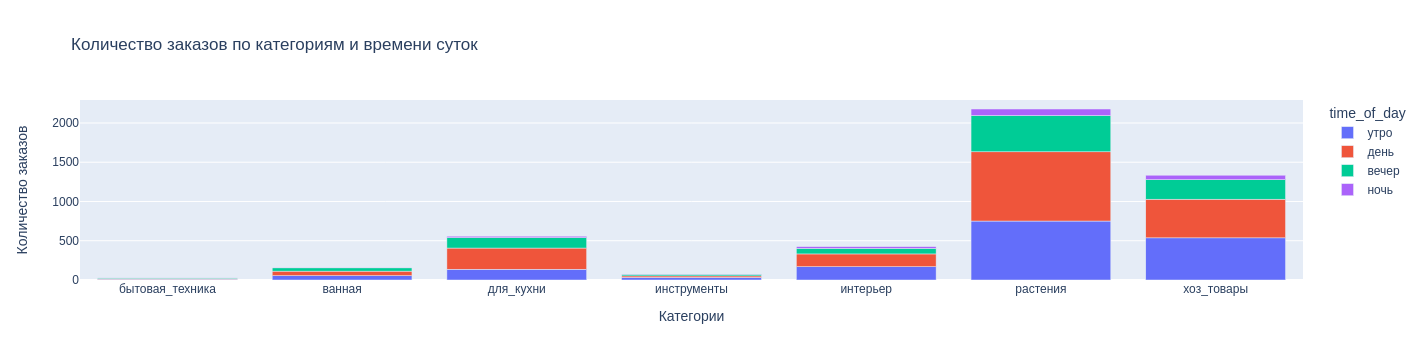

In [166]:
fig = px.bar(orders_by_category_and_time, x="category", y="order_id", color="time_of_day", title="Количество заказов по категориям и времени суток", labels={
            "order_id": "Количество заказов",
            "category": "Категории"})
fig.show()

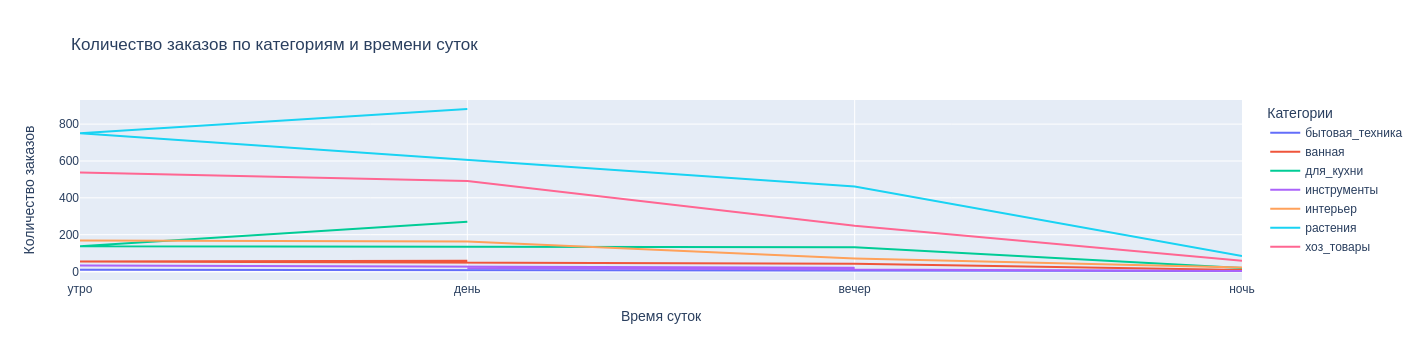

In [167]:
fig = px.line(orders_by_category_and_time, x="time_of_day", y="order_id", color="category",
              labels={
                  "time_of_day": "Время суток",
                  "order_id": "Количество заказов",
                  "category": "Категории"
              },
              title="Количество заказов по категориям и времени суток",
              category_orders={"time_of_day": ["утро", "день", "вечер", "ночь"]}
)
fig.show()

   
    1. Заказы бытовой техники чаще делают в утренние часы, чуть меньше спрос в дневные и вечерние часы.
	2. Заказы товаров для ванной чаще совершают в первой половине дня, вечером и ночью наблюдается спад по заказам.
	3. Товары для кухни чаще заказывают в дневное время.
	4. Инструменты чаще заказывают в утренние часы.
	5. Товары для интерьера покупатели заказывают чаще в первой половине дня.
	6. Растения и хоз товары пользуются спросом в первой половине дня.

## Посмотрим на топ-5 продаваемых товаров по количеству

In [168]:
product_quantity = store.groupby(['product', 'category'])['quantity'].sum().sort_values(ascending=False).reset_index()
top_5_product = product_quantity.head(5)
top_5_product

,product,category,quantity
0,муляж яблоко зеленый 9 см полиуретан,интерьер,148
1,муляж банан желтый 21 см полиуретан,интерьер,109
2,щетка-сметка 4-х рядная деревянная 300 мм (фиг...,хоз_товары,105
3,"ёрш унитазный с деревянной ручкой , ваир 1712012",хоз_товары,103
4,"стяжка оконная с болтом ст-55 цинк, 1108354",инструменты,100


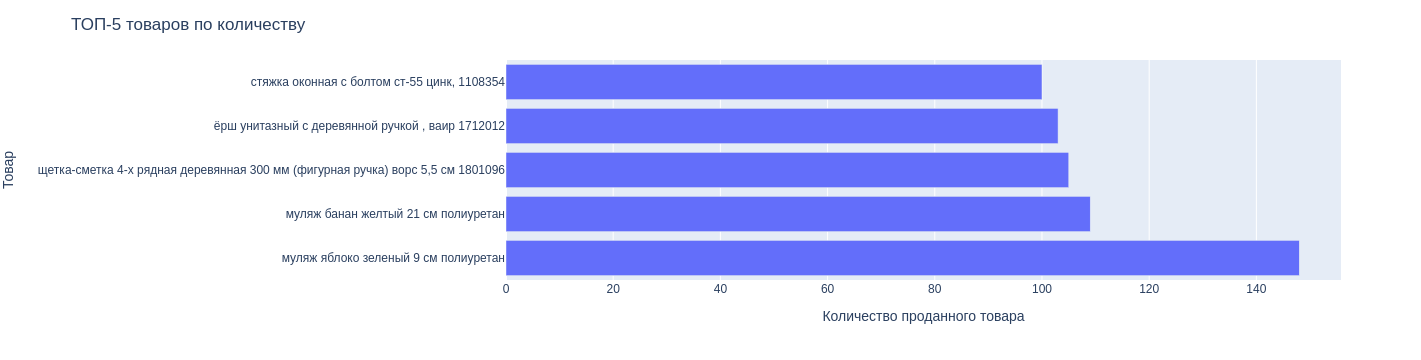

In [169]:
fig = px.bar(top_5_product, x='quantity', y='product', orientation='h')
fig.update_layout(title='ТОП-5 товаров по количеству', xaxis_title='Количество проданного товара', yaxis_title='Товар')
fig.show()

<div style="border:solid #2da9cf 2px; padding: 20px">

    1. В топ-5 по количеству проданного товара вошли товарные категории "интерьер", "хоз_товары" и "инструменты", это говорит нам о разнообразии предпочтений у покупателей.
    2. Товары из категории "интерьер" (муляж яблоко и муляж банан)заняли две верхние позиции в топ-5, что может указывать на то, что данная категория товаров пользуется спросом у покупателей.
    3. Популярность товаров из категории "хоз_товары" (ёрш унитазный и щетка-сметка) может указывать на то, что данная категория является необходимой для повседневного использования и имеет стабильный спрос.
    4. Продажи стяжки оконной указывают на то, что данная категория (инструменты) может быть интересной для покупателей и иметь потенциал для роста продаж.
    

## Посмотрим на топ-5 продаваемых товаров по выручке

In [170]:
product_revenue = store.groupby(['product', 'category'])['revenue'].sum().sort_values(ascending=False).reset_index()
top_5_products = product_revenue.head(5)
top_5_products


,product,category,revenue
0,сумка-тележка 2-х колесная gimi argo синяя,хоз_товары,50405
1,сумка-тележка хозяйственная andersen scala sho...,хоз_товары,28045
2,сумка-тележка 3-х колесная gimi tris floral синяя,хоз_товары,18893
3,сумка-тележка хозяйственная andersen treppenst...,хоз_товары,18560
4,сумка-тележка хозяйственная andersen scala sho...,хоз_товары,18296


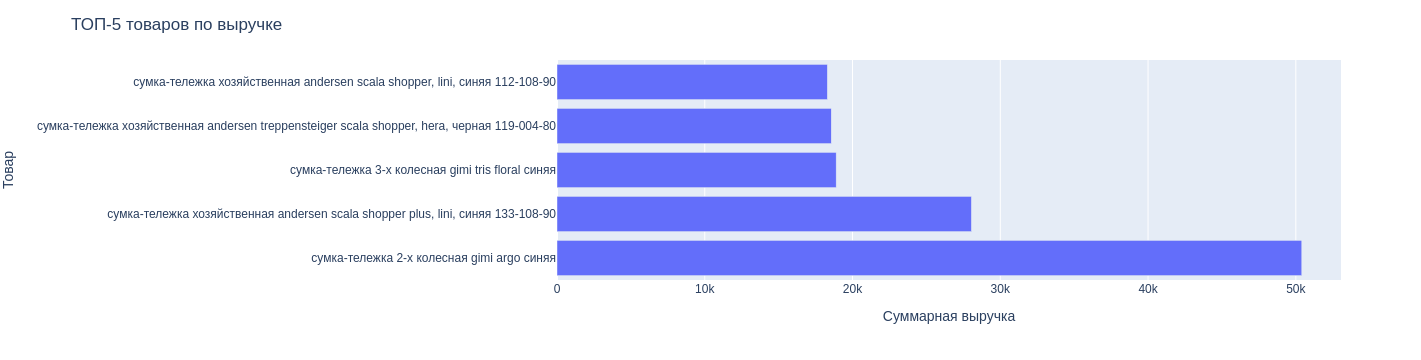

In [171]:
fig = px.bar(top_5_products, x='revenue', y='product', orientation='h')
fig.update_layout(title='ТОП-5 товаров по выручке', xaxis_title='Суммарная выручка', yaxis_title='Товар')
fig.show()

<div style="border:solid #2da9cf 2px; padding: 20px">
    
    Из топ-5 продуктов по выручке видно, что все они относятся к категории хоз товары. Это может означать, что продажи в этой категории являются наиболее прибыльными для нашего интернет-магазина. Кроме того, можно заметить, что все продукты из топ-5 относятся к категории сумок-тележек. Это может указывать на то, что спрос на сумки-тележки довольно высокий, и имеет смысл продолжать предлагать широкий выбор товаров в этой категории для удовлетворения потребностей покупателей.

## Посмотрим подробнее на сезонность для категорий товаров

In [172]:
#определим сезон на основе значения месяца в каждой строке датафрейма
def season(row):
    if  3 <= int(row['month']) <= 5: 
        return 'весна'
    elif 6 <= int(row['month']) <= 8:
        return 'лето'
    elif 9 <= int(row['month']) <= 11:
        return 'осень'
    else:
        return 'зима'
    
store['season'] = store.apply(season, axis = 1)
#store

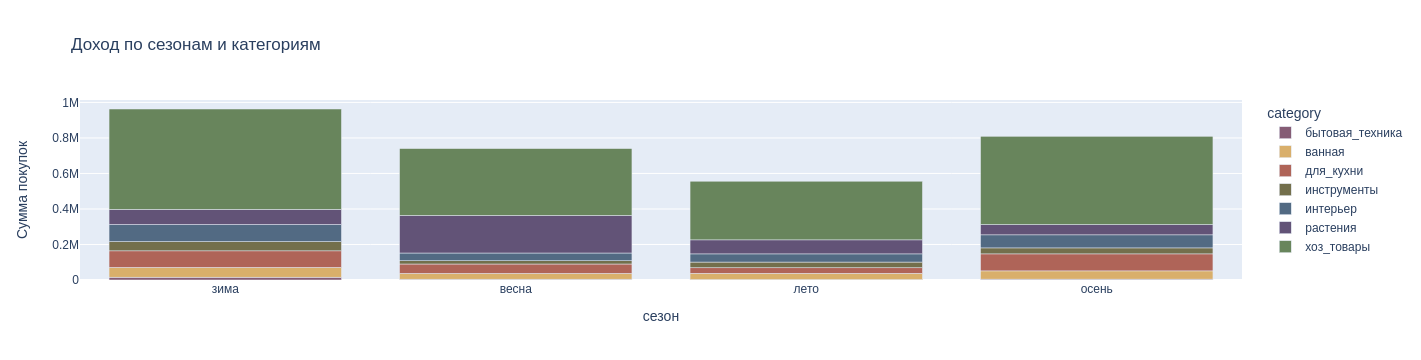

In [173]:
df = store.groupby(['category', 'season'], as_index=False).agg({'revenue': 'sum'})
fig = px.bar(df, x='season', y='revenue', color='category', 
             category_orders={'season': ['зима', 'весна', 'лето', 'осень']},
             title='Доход по сезонам и категориям', 
             labels={'season': 'сезон', 'revenue': 'Сумма покупок'},
             color_discrete_sequence=px.colors.qualitative.Antique)
fig.show()

    
	С учетом сезонности и объема выручки, можно выделить следующее:
	1. Выручка по категории бытовая техника выше зимой и значительно ниже в остальные сезоны
	2. Выручка по категории ванная выше зимой и примерно на половину ниже в остальные периоды
	3. Выручка по категории для кухни выше всего в зимний период и меньше всего в летний
	4. Выручка по категории инструменты больше зимой, меньше всего осенью
	5. Выручка по категории интерьер также выше в зимний период, в остальные она распределена более равномерно в пределах ~40 тыс. руб
	6. Выручка по категории растения выше весной, что мы уже ни раз видели на графиках, меньше всего выручка осенью
	7. Выручка по категории хоз товары также выше зимой, в остальные сезоны она распределена более равномерно.

## Предварительные выводы

**1. Для категории растения можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Сезонность является ключевым фактором, влияющим на выручку от продаж растений. Наибольшая выручка наблюдается весной, в то время как осенью она снижается. Следовательно, необходимо увеличивать рекламную активность и маркетинговые мероприятия весной, чтобы увеличить продажи. Например, можно предложить скидки на определенные виды растений или провести рекламную кампанию, чтобы привлечь внимание к этой категории товаров в период наивысшей популярности.
2. Растения пользуются спросом в начале недели, в понедельник, вторник и четверг, в выходные дни спад по заказам. Также выручка от продаж растений выше в первой половине дня, особенно в дневные часы. Это означает, что следует уделить особое внимание рекламной кампании в начале недели и в дневное время. Также, учитывая период, когда растения пользуются наибольшим спросом, следует скорректировать график работы сотрудников и техническую поддержку интернет-магазина.
3. В апреле и мае происходит наибольший спрос на растения, однако декабре также наблюдался небольшой скачок в количестве заказов. Можно провести дополнительное исследование, чтобы выяснить, почему количество заказов в промежуточном декабре возросло, исходя из этой информации можно провести более эффективные маркетинговые кампании в предновогодний период. Растения могут быть популярны не только для личного использования, но и в качестве подарков, поэтому стоит рассмотреть возможность проведения маркетинговых кампаний на эту тему в преддверии праздников, которые сопровождаются обменом подарками.
  
**2. Для категории хоз_товары можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Категория хоз товаров приносит хорошую выручку ежемесячно, но снижается в январе, мае и июне. в периоды праздников, выходных и отпусков. Маркетинговый отдел может рассмотреть возможность проведения дополнительных акций и рекламных кампаний в эти периоды, чтобы стимулировать продажи. 2. Количество заказов по категории хоз товаров ежемесячно то повышается, то понижается. Это может указывать на успешную работу маркетингового отдела, который разрабатывает и внедряет акции, скидки и рекламные кампании.
3. Хоз товары продаются лучше в будни, чем в выходные дни. Маркетинговый отдел может рассмотреть возможность проведения акций и рекламных кампаний, направленных на привлечение покупателей в выходные дни.
4. Хоз товары приносят хорошую выручку в первой половине дня, лучше всего в утренние часы. Маркетинговый отдел может рассмотреть возможность проведения акций и рекламных кампаний, направленных на привлечение покупателей в этот период.
  
**3. Для категории для кухни можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Пик по выручке приходится на период октябрь-декабрь 2018 года, а самая низкая выручка была получена в апреле и августе 2019 года.
2. Товары для кухни продаются лучше с понедельника по четверг, а в пятницу наблюдается понижение продаж.
3. Товары для кухни приносят большую выручку в дневное время и в зимний период.
4. Количество заказов по категории для кухни варьируется в зависимости от сезона, с наименьшим количеством заказов в летний период и наибольшим в зимний период.
5. Клиенты также заказывают товары для кухни на регулярной основе, преимущественно в среду и четверг, и чаще всего делают заказы в дневное время. Следует обратить внимание на то, что товары для кухни продаются лучше в будние дни и в дневное время, и адаптировать свои маркетинговые стратегии и продажные тактики в соответствии с этими тенденциями.

**4. Для категории интерьер можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Следует сосредоточить усилия на продажах товаров для интерьера в среду и четверг. Это дни, когда товары для интерьера приносят наибольшую прибыль. Можно увеличить количество продаж в эти дни и рассмотреть возможность запуска специальных акций или скидок в эти дни, чтобы привлечь больше покупателей.
2. Поскольку товары для интерьера выгоднее продаются днем, стоит сосредоточиться на продвижении этих товаров в этот период времени. Например, можно настроить таргетированную рекламу в соц сетях, чтобы ее увидели потенциальные клиенты в этот период времени.
3. Исходя из того, что спрос на товары для интерьера наиболее высок в апреле, рекомендуется запустить специальные рекламные кампании в этот период времени. Можно стимулировать покупателей покупать товары для интерьера в этот месяц и предоставлять им дополнительные бонусы или скидки.
4. Стоит обратить внимание на то, что выручка по категории интерьер выше в зимний период. В этот период времени стоит увеличить бюджет на рекламные кампании для этой категории товаров и увеличить объем запасов на складе, чтобы удовлетворять повышенный спрос.

**5. Для категории ванная можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Следует сосредоточить маркетинговые усилия на понедельниках, так как этот день приносит наибольшую выручку.
2. Можно настроить рекламные кампании и акции на первую половину дня, так как это время наиболее благоприятно для продаж товаров для ванной.
3. Следует обратить внимание на март, который был пиковым месяцем продаж. Подумать о специальных предложениях или скидках на товары для ванной в этот период, чтобы привлечь больше покупателей.
4. Дополнительно можно изучить поведение покупателей в дни с пониженным спросом (среду, пятницу и субботу) и определите, возможно ли улучшить продажи в эти дни, а также причины падения продаж в период с апреля по июнь и определить возможные способы увеличения выручки в этот период.
5. Подумать над возможностью улучшить пользовательский опыт для клиентов, которые покупают товары для ванной вечером и ночью, например, предложив более удобный способ заказа или бесплатную доставку.

**6. Для категории инструменты можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Нужно хорошо подготовиться к продвижению категории инструменты в октябре, так как этот месяц приносит наибольшую прибыль по данной категории.
2. Необходимо сделать упор на продажу инструментов по вторникам и четвергам т.к. это дни, когда прибыль по данной категории наивысшая. Следует избегать продаж в субботу т.к. в этот день наблюдается значительный спад прибыли.
3. Можно рассмотреть возможность запуска акций и специальных предложений на инструменты в утренние часы, когда они наиболее выгодно продаются.
4. Рекомендуется уделить внимание продвижению категории зимой т.к. в этот период выручка по данной категории выше, а также привлечению большего количества покупателей в месяцах, когда заказов было меньше всего (март, апрель и сентябрь).
5. Можно провести доп анализ предпочтений ЦА и разработать персонализированные рекламные кампании, которые могут быть наиболее привлекательны для потенциальных покупателей из данной категории.

**7. Для категории бытовая техника можно сделать следующие выводы и рекомендации для отделов маркетинга и продаж:**
1. Можно увеличить рекламные кампании и скидки на бытовую технику в декабре, чтобы увеличить продажи в период новогодних праздников.
2. Учитывая, что больше всего заказов было совершено по понедельникам и вторникам, можно сосредоточить усилия на рекламе и продвижении товаров в эти дни.
3. Можно стимулировать продажи бытовой техники в утренние и дневные часы, например, предлагать доп скидки и акции в эти периоды.
4. Можно разработать стратегию продаж на сезонность, учитывая, что выручка по категории бытовая техника выше зимой и ниже в другие сезоны, а также учесть данные по самым и наименее успешным дням и временам продаж.
5. Также, можно провести доп исследование предпочтений и интересов клиентов в отношении бытовой техники, чтобы сосредоточиться на популярных товарах и охватить широкую аудиторию.

# Сегментация покупателей

## Проведем кластеризацию пользователей

In [174]:
store.head()

,date,customer_id,order_id,product,quantity,price,year,week,month,hour,day_of_week,revenue,category,month_year,time_of_day,season
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,40,10,0,Monday,142,растения,2018-10,ночь,осень
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,40,10,0,Monday,194,растения,2018-10,ночь,осень
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,40,10,0,Monday,112,растения,2018-10,ночь,осень
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,40,10,0,Monday,179,растения,2018-10,ночь,осень
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,40,10,0,Monday,112,растения,2018-10,ночь,осень


In [175]:
#используем функцию OneHotEncoder для преобразования категориальной категории объектов в объекты с двоичным кодированием 
enc = OneHotEncoder(handle_unknown = 'ignore')
feature_arr = enc.fit_transform(store[['category']]).toarray()
feature_labels = enc.categories_

In [176]:
data_features = pd.DataFrame(feature_arr, columns=feature_labels)
data_features = data_features.astype(int)
data = store.reset_index().drop(['index'], axis = 1).join(data_features)

In [177]:
data.columns

Index([              'date',        'customer_id',           'order_id',
                  'product',           'quantity',              'price',
                     'year',               'week',              'month',
                     'hour',        'day_of_week',            'revenue',
                 'category',         'month_year',        'time_of_day',
                   'season', ('бытовая_техника',),          ('ванная',),
             ('для_кухни',),     ('инструменты',),        ('интерьер',),
              ('растения',),      ('хоз_товары',)],
      dtype='object')

In [178]:
#сгруппируем датафрейм по customer_id и агрегируем значения для указанных столбцов
df_cluster = data.groupby('customer_id').agg({'order_id':'nunique',
                                               'quantity':'mean',
                                               'revenue':'sum',
                                               'price':'mean',
                                               ('бытовая_техника',):'sum',
                                               ('ванная',):'sum',
                                               ('для_кухни',):'sum',
                                               ('инструменты',):'sum',
                                               ('интерьер',):'sum',
                                               ('растения',):'sum',
                                               ('хоз_товары',):'sum'})

# print the first 5 rows of the resulting DataFrame
df_cluster.head()

,order_id,quantity,revenue,price,"(бытовая_техника,)","(ванная,)","(для_кухни,)","(инструменты,)","(интерьер,)","(растения,)","(хоз_товары,)"
customer_id,,,,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.00,555,138.75,0,0,0,0,0,4,0
001cee7f-0b29-4716-b202-0042213ab038,1,1.00,442,442.00,0,0,0,0,0,0,1
00299f34-5385-4d13-9aea-c80b81658e1b,1,2.00,914,457.00,0,0,0,0,0,0,1
002d4d3a-4a59-406b-86ec-c3314357e498,1,1.00,1649,1649.00,0,0,0,0,0,0,1
003bbd39-0000-41ff-b7f9-2ddaec152037,1,2.00,2324,1162.00,0,0,0,0,0,0,1


In [179]:
x = df_cluster.reset_index().drop(['customer_id'], axis=1)
# преобразуем имена столбцов в строки
x.columns = x.columns.map(str)

#масштабируем объекты в датафрейме с помощью функции StandardScaler
scaler = StandardScaler() 
x_sc = scaler.fit_transform(x)

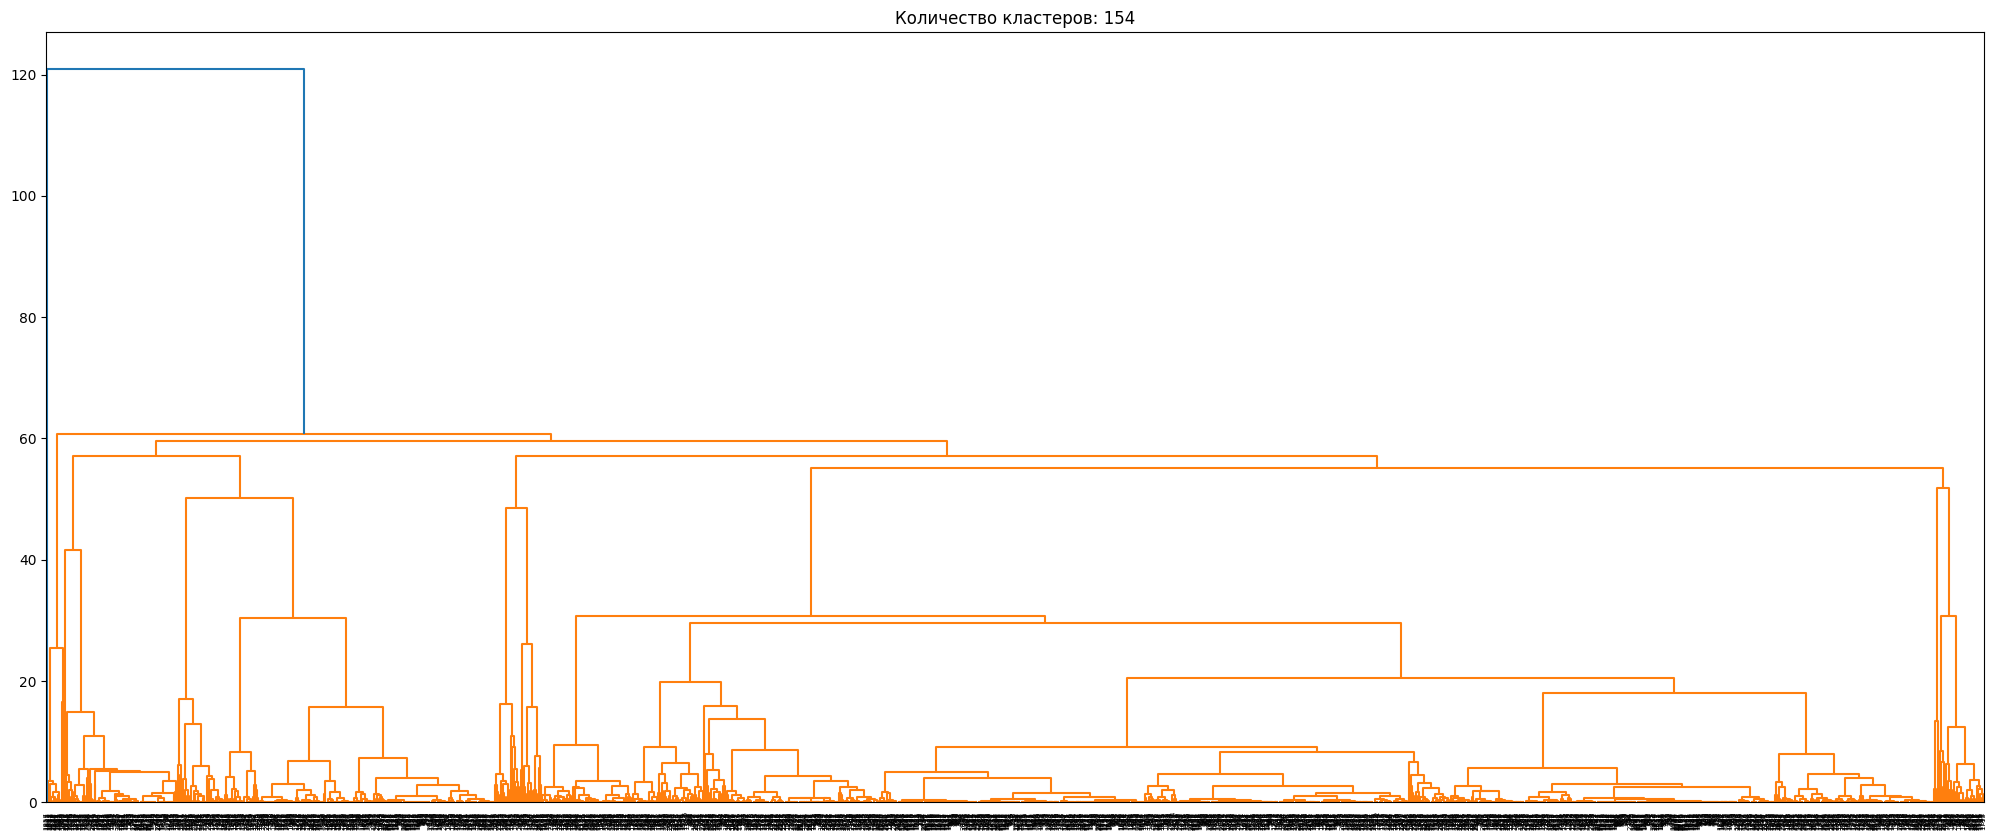

In [180]:
#сгенерируем матрицу иерархического дерева кластеров
linked = linkage(x_sc, method = 'ward')

#построим график дендрограммы
plt.figure(figsize=(25, 10))  
dendrogram(linked, orientation='top')

#полученим спискок номеров кластеров для каждого объекта
labels = fcluster(linked, t=2, criterion='distance')

#выведем количество кластеров
n_clusters = len(set(labels))
plt.title("Количество кластеров: %d" % n_clusters)

plt.xlabel('')
plt.show()


    
    Для оптимального количества кластеров попробуем воспользоваться методом DBSCAN т.к. метод не требует указания числа кластеров заранее, что позволяет автоматически определять число кластеров в зависимости от плотности расположения точек данных. Также DBSCAN может обрабатывать шумные и выбросные данные, которые могут оказывать влияние на результаты кластеризации, включая покупателей, которые не попадают в явные кластеры, но все же обладают определенными характеристиками.
    т.о. DBSCAN может помочь в определении более точных и уникальных сегментов покупателей, что в свою очередь позволит интернет-магазину эффективнее настраивать свои маркетинговые кампании, персонализированные рекомендации и услуги, а также повысить уровень удовлетворенности своих клиентов.

In [198]:
#зададим модель DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=20)
labels = dbscan.fit_predict(x_sc)
df_cluster['cluster'] = labels

#посмотрим на количество покупателей в кластерах
df_cluster.cluster.value_counts()

cluster
 1    864
 0    510
-1    459
 3    202
 4    193
 2    103
 5     49
Name: count, dtype: int64

In [199]:
#сгруппируем клиентов по назначенному им кластеру, а затем вычислим среднее значение числовых переменных
df_cluster.groupby('cluster').mean().T

cluster,-1,0,1,2,3,4,5
order_id,1.64,1.07,1.00,1.00,1.00,1.00,1.61
quantity,7.70,1.42,1.18,1.22,3.26,2.14,1.16
revenue,3152.64,474.67,1139.50,806.28,499.26,684.01,1618.65
price,1134.64,212.08,1070.69,749.79,346.07,502.51,752.77
"(бытовая_техника,)",0.06,0.00,0.00,0.00,0.00,0.00,0.00
"(ванная,)",0.13,0.00,0.00,1.00,0.00,0.00,0.00
"(для_кухни,)",0.80,0.00,0.00,0.00,0.00,1.00,0.00
"(инструменты,)",0.17,0.00,0.00,0.00,0.00,0.00,0.00
"(интерьер,)",0.49,0.00,0.00,0.00,1.00,0.00,0.00
"(растения,)",2.23,2.26,0.00,0.00,0.00,0.02,0.00


In [200]:
#объединим два датафрейма df_cluster и store по столбцу customer_id
df_filtered = df_cluster.merge(store, left_on='customer_id', right_on='customer_id')

In [201]:
df_filtered.head()

,customer_id,order_id_x,quantity_x,revenue_x,price_x,"(бытовая_техника,)","(ванная,)","(для_кухни,)","(инструменты,)","(интерьер,)",...,year,week,month,hour,day_of_week,revenue_y,category,month_year,time_of_day,season
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.00,555,138.75,0,0,0,0,0,...,2019,42,13,8,Wednesday,150,растения,2019-10,утро,зима
1,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.00,555,138.75,0,0,0,0,0,...,2019,42,13,8,Wednesday,135,растения,2019-10,утро,зима
2,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.00,555,138.75,0,0,0,0,0,...,2019,42,13,8,Wednesday,135,растения,2019-10,утро,зима
3,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.00,555,138.75,0,0,0,0,0,...,2019,42,13,8,Wednesday,135,растения,2019-10,утро,зима
4,001cee7f-0b29-4716-b202-0042213ab038,1,1.00,442,442.00,0,0,0,0,0,...,2019,7,2,11,Saturday,442,хоз_товары,2019-02,утро,зима


In [202]:
df_filtered.columns

Index([       'customer_id',         'order_id_x',         'quantity_x',
                'revenue_x',            'price_x', ('бытовая_техника',),
                ('ванная',),       ('для_кухни',),     ('инструменты',),
              ('интерьер',),        ('растения',),      ('хоз_товары',),
                  'cluster',               'date',         'order_id_y',
                  'product',         'quantity_y',            'price_y',
                     'year',               'week',              'month',
                     'hour',        'day_of_week',          'revenue_y',
                 'category',         'month_year',        'time_of_day',
                   'season'],
      dtype='object')

In [203]:
#агрегируем данные на уровне кластера и посчитаем несколько показателей
orders_filt_clust = (
    df_filtered.groupby("cluster")
    .agg(
        {
            "customer_id": "nunique", #количество уникальных покупателей
            "order_id_y": "nunique",  #количество уникальных заказов
            "product": "count",       #количество товаров
            "quantity_y": "sum",      #общее количество заказанных товаров
            "price_y": "mean",        #средняя цена товара
            "revenue_y": "sum",       #общий доход
        }
    )
    .reset_index()
    .rename(
        columns={
            "customer_id": "num_customers", #количество уникальных покупателей
            "order_id_y": "num_orders", #количество уникальных заказов
            "product": "num_products", #количество товаров
            "quantity_y": "total_quantity", #общее количество заказанных товаров
            "price_y": "avg_price", #средняя цена товара
            "revenue_y": "total_revenue", #общий доход
        }
    )
)

#orders_filt_clust

In [204]:
#вычислим доп. показатели и сохраним их в новых столбцах датафрейма
#среднее количество заказов на одного покупателя
orders_filt_clust['avg_orders_per_buyer'] = round(orders_filt_clust['num_orders']/orders_filt_clust['num_customers'],0)
#средний чек за заказ
orders_filt_clust['avg_order_value'] = orders_filt_clust['total_revenue'] / orders_filt_clust['num_orders']
#среднее количество товаров на одного покупателя
orders_filt_clust['avg_products_per_customer'] = round(orders_filt_clust['total_quantity'] / orders_filt_clust['num_customers'], 0)
#orders_filt_clust

In [205]:
#выведем информацию о кластерах с использованием новых показателей
for cluster_id in orders_filt_clust['cluster']:
    cluster_info = orders_filt_clust[orders_filt_clust['cluster'] == cluster_id]
    print(f"\nКластер {cluster_id}")
    print(f"Количество уникальных покупателей: {int(cluster_info['num_customers'])}")
    print(f"Количество уникальных заказов: {int(cluster_info['num_orders'])}")
    print(f"Количество товаров: {int(cluster_info['num_products'])}")
    print(f"Общее количество заказанных товаров: {int(cluster_info['total_quantity'])}")
    print(f"Средняя цена товара: {round(cluster_info['avg_price'], 2)}")
    print(f"Общий доход: {round(cluster_info['total_revenue'], 2)}")
    print(f"Среднее количество заказов на одного покупателя: {int(cluster_info['avg_orders_per_buyer'])}")
    print(f"Средний чек за заказ: {round(cluster_info['avg_order_value'], 2)}")
    print(f"Среднее количество товаров на одного покупателя: {int(cluster_info['avg_products_per_customer'])}")



Кластер -1
Количество уникальных покупателей: 459
Количество уникальных заказов: 751
Количество товаров: 2150
Общее количество заказанных товаров: 6601
Средняя цена товара: 0   463.76
Name: avg_price, dtype: float64
Общий доход: 0    1447062
Name: total_revenue, dtype: int64
Среднее количество заказов на одного покупателя: 2
Средний чек за заказ: 0   1926.85
Name: avg_order_value, dtype: float64
Среднее количество товаров на одного покупателя: 14

Кластер 0
Количество уникальных покупателей: 510
Количество уникальных заказов: 544
Количество товаров: 1151
Общее количество заказанных товаров: 1587
Средняя цена товара: 1   169.95
Name: avg_price, dtype: float64
Общий доход: 1    242082
Name: total_revenue, dtype: int64
Среднее количество заказов на одного покупателя: 1
Средний чек за заказ: 1   445.00
Name: avg_order_value, dtype: float64
Среднее количество товаров на одного покупателя: 3

Кластер 1
Количество уникальных покупателей: 864
Количество уникальных заказов: 864
Количество това

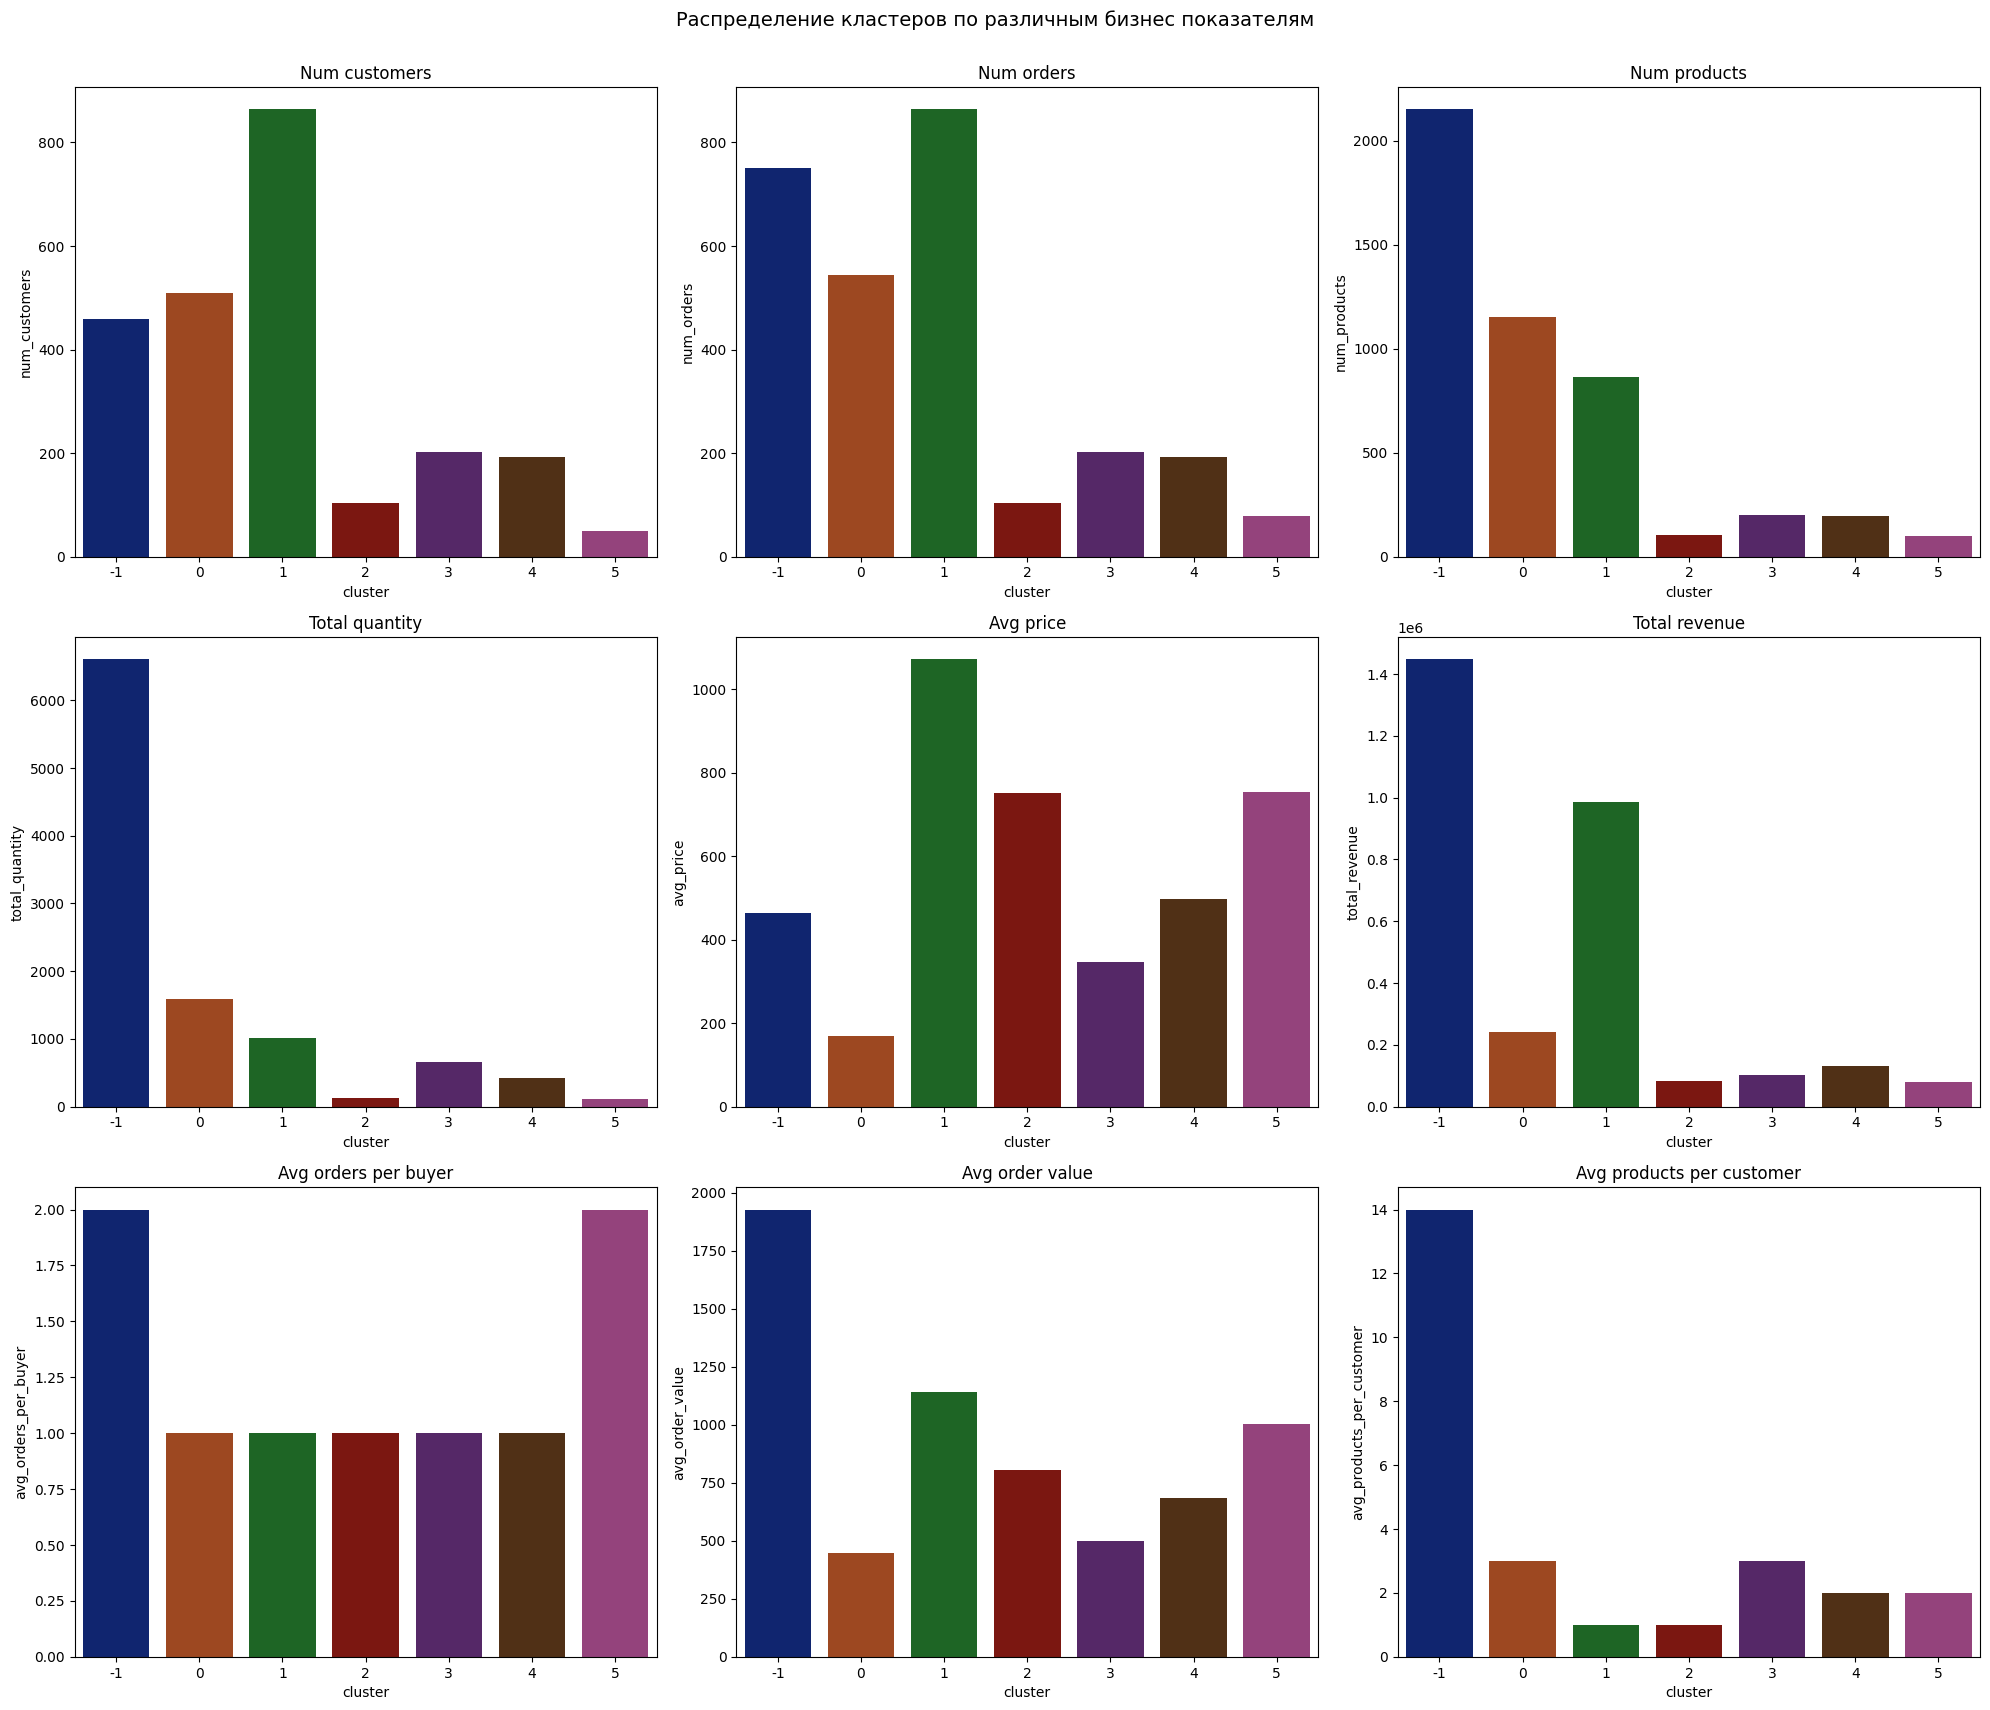

In [189]:
#сгенерируем гистограмму различных показателей по кластерам
WIDTH = 3
plot_amount = len(orders_filt_clust.columns)
height = plot_amount//WIDTH

fig, axs = plt.subplots(height, WIDTH, figsize=(20, 17))
fig.suptitle('Распределение кластеров по различным бизнес показателям',  y=1.003, size=14)

for item, ax in zip(orders_filt_clust.columns[1:], np.ravel(axs)):
    sns.barplot(data = orders_filt_clust, x='cluster', y=item, ax=ax, palette='dark')
    ax.set_title(item.capitalize().replace('_', ' '), size=12)

plt.tight_layout()
plt.show()

    
    -1 кластер характеризуется средним количеством покупателей - 459 чел., большим количеством заказов - 751. При этом количество купленных товаров составляет 2150 шт., средняя стоимость товара - 463.75 руб., а средний чек составляет - 1926.84 руб. Среднее количество заказов на 1 покупателя составляет - 2, среднее количество товаров на одного покупателя - 14 шт. Выручка от продажи товаров данной группе покупателей составила 1447062 руб.
    
    0 кластер характеризуется средним количеством покупателей - 510 чел., количеством заказов - 544. При этом количество купленных товаров составляет 1151 шт., средняя стоимость товара - 169.94 руб., а средний чек составляет - 445 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 3 шт. Выручка от продажи товаров данной группе покупателей составила 242082 руб.
    
    1 кластер характеризуется небольшим количеством покупателей - 864 чел., количеством заказов - 864. При этом количество купленных товаров 864 шт., средняя стоимость товара очень высокая - 1070.68 руб., а средний чек составляет - 1139.50 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 1 шт. Выручка от продажи товаров данной группе покупателей составила 984532 руб.
   
    2 кластер характеризуется низким количеством покупателей - 103 чел., таким же количеством заказов - 103 и чуть большим количеством купленных товаров 126 шт. Средняя стоимость товара составляет 749.78 руб., а средний чек составляет - 806.28 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 1 шт. Выручка от продажи товаров данной группе покупателей составила 83047 руб.
    
    3 кластер характеризуется количеством покупателей - 202 чел., количеством заказов - 202. При этом количество купленных товаров составляет 658 шт., средняя стоимость товара самая - 346.07 руб., а средний чек составляет - 499.25 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 3 шт. Выручка от продажи товаров данной группе покупателей составила 100850 руб.
    
    4 кластер характеризуется небольшим количеством покупателей - 193 чел., небольшим количеством заказов - 193. При этом количество купленных товаров составляет 196 шт., средняя стоимость товара - 496.35 руб., а средний чек - 684 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 2 шт. Выручка от продажи товаров данной группе покупателей составила 132013 руб.
    
    5 кластер характеризуется самым низким количеством покупателей - 49 чел., и количеством заказов - 79. При этом количество купленных товаров составляет 114 шт., средняя стоимость товара - 752.76 руб., а средний чек высокий - 1003.97 руб. Среднее количество заказов на 1 покупателя составляет - 2, среднее количество товаров на одного покупателя - 2 шт. Выручка составила 79314 руб.

## Посмотрим сезонность популярных категорий по нашим кластерам

In [190]:
#сгруппируем заказы по категориям, сезонам и кластерам
orders_by_category_season_cluster = df_filtered.groupby(['category', 'season', 'cluster']).size().reset_index(name='order_count')

#посчитаем общее количество заказов по категориям и кластерам
orders_by_category_cluster = orders_by_category_season_cluster.groupby(['category', 'cluster']).agg({'order_count': 'sum'}).reset_index()

#объединим таблицы для расчета доли заказов по категориям и кластерам в каждом сезоне
merged_df = pd.merge(orders_by_category_season_cluster, orders_by_category_cluster, on=['category', 'cluster'])

#добавимм столбец с долей заказов по категории и кластеру в каждом сезоне
merged_df['order_share'] = merged_df['order_count_x'] / merged_df['order_count_y']

#сделаем группировку по категориям, сезонам и кластерам
#выведем топ-5 популярных категорий в каждом кластере с указанием сезона
for cluster_id in df_filtered['cluster'].unique():
    cluster_df = merged_df[merged_df['cluster'] == cluster_id]
    for season in df_filtered['season'].unique():
        season_df = cluster_df[cluster_df['season'] == season]
        popular_categories = season_df.groupby('category')['order_share'].sum().sort_values(ascending=False).head(5)
        print(f'Top-5 популярных категорий в кластере {cluster_id} в сезоне {season}:')
        print(popular_categories)



Top-5 популярных категорий в кластере 0 в сезоне зима:
category
растения   0.19
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 0 в сезоне осень:
category
растения   0.19
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 0 в сезоне лето:
category
растения   0.19
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 0 в сезоне весна:
category
растения   0.44
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 1 в сезоне зима:
category
хоз_товары   0.34
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 1 в сезоне осень:
category
хоз_товары   0.23
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 1 в сезоне лето:
category
хоз_товары   0.24
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере 1 в сезоне весна:
category
хоз_товары   0.19
Name: order_share, dtype: float64
Top-5 популярных категорий в кластере -1 в сезоне зима:
category
бытовая_тех

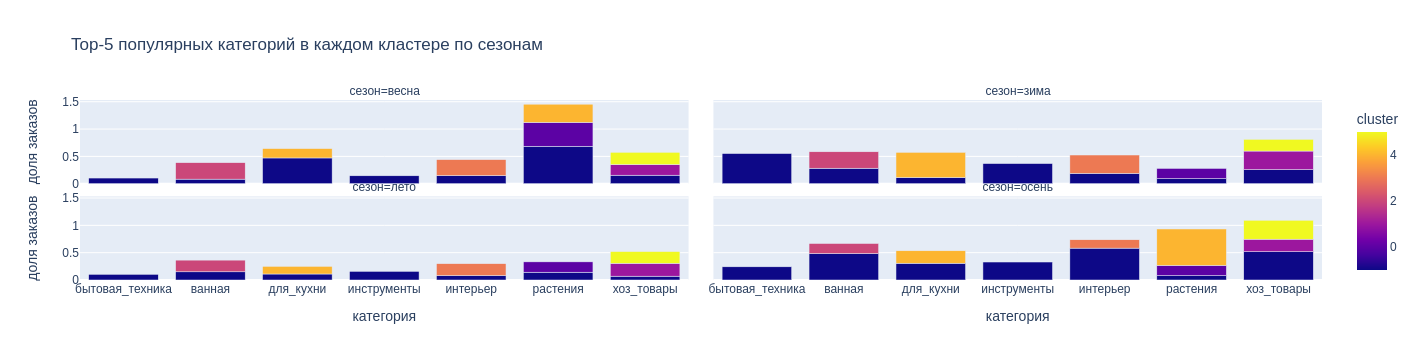

In [191]:
#выведем топ популярных категорий в каждом кластере с указанием сезона
fig = px.bar(merged_df, x="category", y="order_share", color="cluster", barmode="group", facet_col="season", facet_col_wrap=2,
             title="Top-5 популярных категорий в каждом кластере по сезонам",
             labels={'order_share': 'доля заказов',
                     'season': 'сезон',
                     'category': 'категория'})

fig.show()


      
    Кластер -1:
    Этот кластер можно охарактеризовать как самый разнообразный в своих интересах клиентов. При этом в каждом сезоне наиболее популярные категории продуктов в этом кластере различаются. Например, в зимний сезон самой популярной категорией являются бытовая техника и инструменты, а в осенний - интерьер и хозяйственные товары.
    
    Кластер 0:
    Наиболее популярной категорией заказов в этом кластере являются растения. Интересно, что доля заказов на растения весной составляет 43,6%, что говорит о том, что клиенты этого кластера в основном интересуются этой категорией продуктов в начале сезона посадки растений.
    
    Кластер 1:
    Основная категория продуктов, заказываемых клиентами этого кластера - это хоз товары. При этом в зимний сезон заказов на эту категорию наиболее высокий показатель (34%), а весной - наименьший (19,4%).
    
    Кластер 2:
    Клиенты этого кластера наиболее заинтересованы в категории "ванная". Доля заказов на эту категорию в каждом из сезонов колеблется в пределах от 18% до 30%, при этом в зимний и весенний сезоны эта категория является самой популярной.
    
    Кластер 3:
    Основной категорией продуктов, заказываемых клиентами этого кластера, является интерьер. Наиболее популярная категория продуктов в зимний сезон (33,7%), но и в летний сезон интерес к этой категории достаточно высокий (21,8%).
    
    Кластер 4:
    Зимой наиболее популярной категорией являются товары для кухни, осенью - растения и товары для кухни, летом - снова товары для кухни, весной - растения и товары для кухни. Кластер 4 может быть отнесен к покупателям, которые интересуются кулинарией и садоводством.
    
    Кластер 5:
    На протяжении всего года наиболее популярной категорией являются также хоз  товары. Кластер 5 может быть отнесен к покупателям, которые часто покупают хоз  товары, возможно, заботятся о домашнем уюте и комфорте.

# Проверка статистических гипотез

## Сформулируем гипотезы:  
**$Н_0$ - Между средней выручкой кластеров нет существенной разницы.**  
**$Н_1$ - Между средней выручкой кластеров есть существенная разница.**

In [192]:
#объявим переменные для кластеров
cluster_1 = df_cluster.query('cluster==-1')['revenue']
cluster0 = df_cluster.query('cluster==0')['revenue']
cluster1 = df_cluster.query('cluster==1')['revenue']
cluster2 = df_cluster.query('cluster==2')['revenue']
cluster3 = df_cluster.query('cluster==3')['revenue']
cluster4 = df_cluster.query('cluster==4')['revenue']
cluster5 = df_cluster.query('cluster==5')['revenue']

Напишем код, который будет выполнять тест Манна-Уитни для всех возможных комбинаций кластеров, применять к полученным p-values поправку методом FDR и выводить информацию о каждой паре кластеров вместе с результатом теста и средними значениями

In [193]:
mas_cluster = [cluster_1, cluster0, cluster1, cluster2, cluster3, cluster4, cluster5]
mas_cluster_str = ['cluster_1', 'cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']

p_values = []
#напишем цикл для сравнения всех возможных комбинаций кластеров с помощью теста Манна-Уитни
for index_one in range(len(mas_cluster)):
    for index_two in range(index_one+1, len(mas_cluster)):
        p_mw = st.mannwhitneyu(mas_cluster[index_one], mas_cluster[index_two], alternative='two-sided')[1]
        p_values.append(p_mw)

#применим поправку FDR к списку p-values        
p_values_corrected = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

count = 0
#напишем цикл for для вывода информации о каждой паре кластеров 
for index_one in range(len(mas_cluster)):
    for index_two in range(index_one+1, len(mas_cluster)):
        print('Кластеры', mas_cluster_str[index_one], mas_cluster_str[index_two])
        print('p_value: {:.5f}'.format(p_values_corrected[count]))
        print('Средняя выручка кластера A: {:.0f}'.format(mas_cluster[index_one].mean()))
        print('Средняя выручка кластера B: {:.0f}'.format(mas_cluster[index_two].mean()))
        if p_values_corrected[count] < 0.05:
            print('Отвергаем нулевую гипотезу: между средними выручками кластеров есть значимая разница\n')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать средние выручки кластеров разными\n')
        count += 1


Кластеры cluster_1 cluster0
p_value: 0.00000
Средняя выручка кластера A: 3153
Средняя выручка кластера B: 475
Отвергаем нулевую гипотезу: между средними выручками кластеров есть значимая разница

Кластеры cluster_1 cluster1
p_value: 0.00000
Средняя выручка кластера A: 3153
Средняя выручка кластера B: 1140
Отвергаем нулевую гипотезу: между средними выручками кластеров есть значимая разница

Кластеры cluster_1 cluster2
p_value: 0.00000
Средняя выручка кластера A: 3153
Средняя выручка кластера B: 806
Отвергаем нулевую гипотезу: между средними выручками кластеров есть значимая разница

Кластеры cluster_1 cluster3
p_value: 0.00000
Средняя выручка кластера A: 3153
Средняя выручка кластера B: 499
Отвергаем нулевую гипотезу: между средними выручками кластеров есть значимая разница

Кластеры cluster_1 cluster4
p_value: 0.00000
Средняя выручка кластера A: 3153
Средняя выручка кластера B: 684
Отвергаем нулевую гипотезу: между средними выручками кластеров есть значимая разница

Кластеры cluster_1 

1. Для множественного сравнительного теста будем использовать U-критерий Манна-Уитни, который можно использовать, даже если размер выборки сильно различается.

2. Возьмем стандартный уровень значимости alpha = 0.05.

3. Одна из особенностей множественного теста заключается в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости для уменьшения FWER. Попробуем воспользоваться методом FDR, при использовании которого уровень значимости не уменьшается так сильно, как при использовании метода Бонферрони, что может позволить обнаружить больше значимых различий, но также может увеличить вероятность ложных положительных результатов.  

    
    По результатам проверки гипотез можно сделать вывод о существенных различиях средней выручки между отдельными кластерами. В частности, гипотеза о равном доходе между кластером 0 и кластером 1, кластером 0 и кластером 3, кластером 1 и кластером 2, кластером 1 и кластером 3, кластером 1 и кластером 4, кластером 2 и кластером 3, кластером 3 и кластером 4 была отклонена на уровне значимости 0,005.
    Однако гипотеза о равном доходе между кластером 0 и кластером 2, кластером 0 и кластером 4, кластером 2 и кластером 4 не была отвергнута при уровне значимости 0,005. 
    Эти результаты показывают, что алгоритм кластеризации эффективно разделил данные на группы с разными характеристиками выручки.

## Сформулируем гипотезы:  
**$Н_0$ - Между средней стоимостью товаров кластеров нет существенной разницы.**  
**$Н_1$ - Между средней стоимостью товаров кластеров есть существенная разница.**

In [194]:
#объявим переменные для кластеров
cluster_1 = df_cluster.query('cluster==-1')['price']
cluster0 = df_cluster.query('cluster==0')['price']
cluster1 = df_cluster.query('cluster==1')['price']
cluster2 = df_cluster.query('cluster==2')['price']
cluster3 = df_cluster.query('cluster==3')['price']
cluster4 = df_cluster.query('cluster==4')['price']
cluster5 = df_cluster.query('cluster==5')['price']

In [195]:
mas_cluster = [cluster_1, cluster0, cluster1, cluster2, cluster3, cluster4, cluster5]
mas_cluster_str = ['cluster_1', 'cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']

p_values = []
#напишем цикл для сравнения всех возможных комбинаций кластеров с помощью теста Манна-Уитни
for index_one in range(len(mas_cluster)):
    for index_two in range(index_one+1, len(mas_cluster)):
        p_mw = st.mannwhitneyu(mas_cluster[index_one], mas_cluster[index_two], alternative='two-sided')[1]
        p_values.append(p_mw)

#применим поправку FDR к списку p-values        
p_values_corrected = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

count = 0
#напишем цикл for для вывода информации о каждой паре кластеров 
for index_one in range(len(mas_cluster)):
    for index_two in range(index_one+1, len(mas_cluster)):
        print('Кластеры', mas_cluster_str[index_one], mas_cluster_str[index_two])
        print('p_value: {:.5f}'.format(p_values_corrected[count]))
        print('Средняя стоимость товара кластера A: {:.0f}'.format(mas_cluster[index_one].mean()))
        print('Средняя стоимость товара кластера B: {:.0f}'.format(mas_cluster[index_two].mean()))
        if p_values_corrected[count] < 0.05:
            print('Отвергаем нулевую гипотезу: между средними стоимостями товаров кластеров есть значимая разница\n')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать средние стоимости товаров кластеров разными\n')
        count += 1


Кластеры cluster_1 cluster0
p_value: 0.00012
Средняя стоимость товара кластера A: 1135
Средняя стоимость товара кластера B: 212
Отвергаем нулевую гипотезу: между средними стоимостями товаров кластеров есть значимая разница

Кластеры cluster_1 cluster1
p_value: 0.00000
Средняя стоимость товара кластера A: 1135
Средняя стоимость товара кластера B: 1071
Отвергаем нулевую гипотезу: между средними стоимостями товаров кластеров есть значимая разница

Кластеры cluster_1 cluster2
p_value: 0.00012
Средняя стоимость товара кластера A: 1135
Средняя стоимость товара кластера B: 750
Отвергаем нулевую гипотезу: между средними стоимостями товаров кластеров есть значимая разница

Кластеры cluster_1 cluster3
p_value: 0.00000
Средняя стоимость товара кластера A: 1135
Средняя стоимость товара кластера B: 346
Отвергаем нулевую гипотезу: между средними стоимостями товаров кластеров есть значимая разница

Кластеры cluster_1 cluster4
p_value: 0.71193
Средняя стоимость товара кластера A: 1135
Средняя стоимост

   
    По результатам проверки гипотезы можно сделать вывод, что средняя стоимость товаров в разных кластерах существенно отличается. В частности, нулевая гипотеза о равной стоимости продуктов в кластерах была отклонена для большинства пар кластеров. Исключение составили пары: кластер0 и кластер2, кластер0 и кластер4, кластер2 и кластер4, где нулевая гипотеза не отвергалась.  
    Это указывает на то, что существует значительная разница в стоимости товаров между большинством кластеров, и эта информация может быть полезна при принятии решений, связанных с ценообразованием продуктов и ориентацией на определенные сегменты клиентов.
    
    В некоторых парах p_value равно 0.00000, это означает, что p-значение меньше, чем наименьшее число, которое может быть представлено компьютером. Однако, если низкое значение p является неожиданным или удивительным, мы можем перепроверить свои данные и анализ, чтобы убедиться в отсутствии ошибок или проблем с данными или предположениями анализа. Одним из возможных тестов для перепроверки результатов является тест ANOVA. Тест ANOVA может определить, есть ли значительная разница между средними значениями трех или более групп. Перепроверим наши результаты.    

## Проведем проверочный тест ANOVA

Сформулируем гипотезы:   
**$Н_0$ - Между средней выручкой кластеров нет существенной разницы.**  
**$Н_1$ - Между средней выручкой кластеров есть существенная разница.**

In [196]:
#присвоим переменные кластерам
cluster_1 = df_cluster.query('cluster==-1')['revenue']
cluster0 = df_cluster.query('cluster==0')['revenue']
cluster1 = df_cluster.query('cluster==1')['revenue']
cluster2 = df_cluster.query('cluster==2')['revenue']
cluster3 = df_cluster.query('cluster==3')['revenue']
cluster4 = df_cluster.query('cluster==4')['revenue']
cluster5 = df_cluster.query('cluster==5')['revenue']

# вычислим среднее значение выручки за заказ (revenue) для каждого кластера
mean_cluster_1 = np.mean(cluster_1)
mean_cluster0 = np.mean(cluster0)
mean_cluster1 = np.mean(cluster1)
mean_cluster2 = np.mean(cluster2)
mean_cluster3 = np.mean(cluster3)
mean_cluster4 = np.mean(cluster4)
mean_cluster5 = np.mean(cluster5)

#выполним тест ANOVA
f_val, p_val = st.f_oneway(cluster_1, cluster0, cluster1, cluster2, cluster3, cluster4, cluster5)

#выведем результаты
print("Результаты теста ANOVA:")
print("F-value:", f_val)
print("P-value:", p_val)

#выведем среднее значение выручки за заказ (revenue) для каждого кластера
print("Средняя выручка для каждого кластера:")
print("Кластер -1:", mean_cluster_1)
print("Кластер 0:", mean_cluster0)
print("Кластер 1:", mean_cluster1)
print("Кластер 2:", mean_cluster2)
print("Кластер 3:", mean_cluster3)
print("Кластер 4:", mean_cluster4)
print("Кластер 5:", mean_cluster5)

alpha = 0.05 / 10
if p_val < alpha:
    print("По крайней мере, один кластер отличается от других (отклоняем H0 гипотезу)")
else:
    print("Существенной разницы между кластерами нет (не удалось отклонить H0 гипотезу)")


Результаты теста ANOVA:
F-value: 27.19248133837242
P-value: 1.6304225548411762e-31
Средняя выручка для каждого кластера:
Кластер -1: 3152.640522875817
Кластер 0: 474.67058823529413
Кластер 1: 1139.5046296296296
Кластер 2: 806.2815533980582
Кластер 3: 499.25742574257424
Кластер 4: 684.0051813471503
Кластер 5: 1618.6530612244899
По крайней мере, один кластер отличается от других (отклоняем H0 гипотезу)


Результаты теста ANOVA говорят о том, что есть статистически значимые различия между выручкой в разных кластерах. F-value равно 27.19, что говорит о том, что средняя выручка между группами отличается настолько значительно, что это не может быть случайным. P-value, равный 1.63042..., говорит о том, что вероятность случайного различия между группами крайне низкая.

Сформулируем гипотезы:   
**$Н_0$ - Между средней стоимостью товаров кластеров нет существенной разницы.**  
**$Н_1$ - Между средней стоимостью товаров кластеров есть существенная разница.**

In [197]:
#присвоим переменные кластерам
cluster_1 = df_cluster.query('cluster==-1')['price']
cluster0 = df_cluster.query('cluster==0')['price']
cluster1 = df_cluster.query('cluster==1')['price']
cluster2 = df_cluster.query('cluster==2')['price']
cluster3 = df_cluster.query('cluster==3')['price']
cluster4 = df_cluster.query('cluster==4')['price']
cluster5 = df_cluster.query('cluster==5')['price']

# вычислим среднее значение стоимости товара в заказе для каждого кластера
mean_cluster_1 = np.mean(cluster_1)
mean_cluster0 = np.mean(cluster0)
mean_cluster1 = np.mean(cluster1)
mean_cluster2 = np.mean(cluster2)
mean_cluster3 = np.mean(cluster3)
mean_cluster4 = np.mean(cluster4)
mean_cluster5 = np.mean(cluster5)

#выполним тест ANOVA
f_val, p_val = st.f_oneway(cluster_1, cluster0, cluster1, cluster2, cluster3, cluster4, cluster5)

#выведем результаты
print("Результаты теста ANOVA:")
print("F-value:", f_val)
print("P-value:", p_val)

#выведем среднее значение выручки за заказ (revenue) для каждого кластера
print("Средняя стоимость товара для каждого кластера:")
print("Кластер -1:", mean_cluster_1)
print("Кластер 0:", mean_cluster0)
print("Кластер 1:", mean_cluster1)
print("Кластер 2:", mean_cluster2)
print("Кластер 3:", mean_cluster3)
print("Кластер 4:", mean_cluster4)
print("Кластер 5:", mean_cluster5)

alpha = 0.05 / 10
if p_val < alpha:
    print("По крайней мере, один кластер отличается от других (отклоняем H0 гипотезу)")
else:
    print("Существенной разницы между кластерами нет (не удалось отклонить H0 гипотезу)")

Результаты теста ANOVA:
F-value: 52.56257410126492
P-value: 4.940359816595052e-61
Средняя стоимость товара для каждого кластера:
Кластер -1: 1134.6435281936351
Кластер 0: 212.08469406954703
Кластер 1: 1070.6898148148148
Кластер 2: 749.7864077669902
Кластер 3: 346.0742574257426
Кластер 4: 502.51468048359243
Кластер 5: 752.765306122449
По крайней мере, один кластер отличается от других (отклоняем H0 гипотезу)


Результаты теста ANOVA говорят о том, что есть статистически значимые различия средних стоимостей товаров между кластерами. F-value равно 52.56, что говорит о том, что средняя стоимость товаров между кластерами отличается настолько значительно, что это не может быть случайным. P-value, равный 4.94035..., говорит о том, что вероятность случайного различия между группами крайне низкая.
    
    
Таким образом, можно сделать вывод, что разбиение на кластеры основанное на признаках, используемых для кластеризации, действительно имеет статистически значимые различия между кластерами, связанными с средними значениями цен.

# Общий вывод с рекомендациями



Цель данного исследования заключается в сегментации покупателей интернет-магазина товаров для дома «Пока все ещё тут» на основе их поведенческих характеристик и истории покупок. Для анализа был использован файл "ecommerce_dataset.csv" с данными о транзакциях покупателей. Данные были обработаны и проанализированы, что позволило выделить основные поведенческие характеристики покупателей и сегментировать их на основе этих характеристик.

В результате исследовательского анализа хочется выделить следующее:
1. По количеству проданного товара, в топ-5 есть несколько наиболее популярных категорий товаров, таких как "интерьер", "хоз_товары" и "инструменты". В частности, товары из категории "интерьер" (муляж яблоко и муляж банан)заняли две верхние позиции в топ-5 по количеству проданного товара 148 шт и 109 соответственно.
Популярность товаров из категории "хоз_товары" (ёрш унитазный - 103 шт и щетка-сметка - 105 шт) может указывать на то, что данная категория является необходимой для повседневного использования и имеет стабильный спрос. Продажи стяжки оконной 100 шт. указывают на то, что данная категория (инструменты) может быть интересной для покупателей и иметь потенциал для роста продаж.

2. Из топ-5 продуктов по выручке видно, продажи товаров из категории хоз товаров являются наиболее прибыльными для интернет-магазина, и сумки-тележки являются востребованными товарами среди покупателей. Сумки-тележки
принесли прибыль от 18296 руб. до 50405 руб.

В результате кластеризации методом DBSCAN мы получили 7 сегментов, исследовали их и дополнительно проверили корректность разбиения на кластеры. По итогу мы можем представить следующие выводы и рекомендации для 
отдела маркетинга интернет-магазина товаров для дома «Пока все ещё тут»:

1. **Кластер -1** характеризуется средним количеством покупателей - 459 чел., большим количеством заказов - 751. При этом количество купленных товаров составляет 2150 шт., средняя стоимость товара - 463.75 руб., а средний чек составляет - 1926.84 руб. Среднее количество заказов на 1 покупателя составляет - 2, среднее количество товаров на одного покупателя - 14 шт. Выручка от продажи товаров данной группе покупателей составила 1447062 руб.
Кластер -1 можно назвать **"Сезонные покупатели с разнообразными интересами"**. Он характеризуется тем, что представлен разнообразными группами покупателей, но все они имеют общую тенденцию к сезонным покупкам и предпочитают различные категории товаров в зависимости от времени года. Например, в зимний сезон самой популярной категорией являются бытовая техника и инструменты, а в осенний - интерьер и хозяйственные товары. Это означает, что для эффективной маркетинговой стратегии в отношении данного кластера необходимо учитывать сезонные факторы и подстраивать предложения под интересы покупателей в соответствующий период времени.

2. **Кластер 0** характеризуется средним количеством покупателей - 510 чел., количеством заказов - 544. При этом количество купленных товаров составляет 1151 шт., средняя стоимость товара - 169.94 руб., а средний чек составляет - 445 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 3 шт. Выручка от продажи товаров данной группе покупателей составила 242082 руб.
Кластер 0 можно назвать **"Любители растений"**. Этот кластер характеризуется тем, что большинство заказов покупателей относится к категории растений, доля заказов на растения весной составляет 43,6%. Это означает, что данный кластер может быть заинтересован в садовых товарах, средствах по уходу за растениями и других сопутствующих товарах. Для эффективной маркетинговой стратегии в отношении данного кластера можно предлагать персонализированные предложения, сезонные скидки на растения и товары для сада, а также рекомендации по уходу за растениями в зависимости от времени года.

3. **Кластер 1** характеризуется небольшим количеством покупателей - 864 чел., количеством заказов - 864. При этом количество купленных товаров 864 шт., средняя стоимость товара очень высокая - 1070.68 руб., а средний чек составляет - 1139.50 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 1 шт. Выручка от продажи товаров данной группе покупателей составила 984532 руб.
Кластер 1 можно назвать **"Любители хозтоваров"**, так как основной категорией продуктов, которые заказывают клиенты в этом кластере, являются хозяйственные товары, при этом они предпочитают делать меньше заказов, но с более высокой суммой покупок, что может говорить о более осознанном подходе к покупкам. Также можно отметить сезонную динамику заказов на хозтовары, которая может быть полезна для планирования маркетинговых акций - в зимний сезон заказов на эту категорию наиболее высокий показатель (34%), а весной - наименьший (19,4%).

4. **Кластер 2** характеризуется низким количеством покупателей - 103 чел., таким же количеством заказов - 103 и чуть большим количеством купленных товаров 126 шт. Средняя стоимость товара составляет 749.78 руб., а средний чек составляет - 806.28 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 1 шт. Выручка от продажи товаров данной группе покупателей составила 83047 руб.
Кластер 2 можно назвать **"Любители товаров для ванны"**. Он характеризуется небольшим количеством покупателей, которые показывают интерес к товарной категории "ванная". Клиенты этого кластера склонны делать заказы с небольшим количеством товаров, но при этом сравнительно высокой средней стоимостью. Доля заказов на эту категорию в каждом из сезонов колеблется в пределах от 18% до 30%, при этом в зимний и весенний сезоны эта категория является наиболее популярной.

5. **Кластер 3** характеризуется количеством покупателей - 202 чел., количеством заказов - 202. При этом количество купленных товаров составляет 658 шт., средняя стоимость товара самая - 346.07 руб., а средний чек составляет - 499.25 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 3 шт. Выручка от продажи товаров данной группе покупателей составила 100850 руб.
Кластер 3 можно назвать **"Любители интерьера"**. Этот кластер имеет высокое количество купленных товаров на одного покупателя, что свидетельствует о высоком интересе к данной категории продуктов. Средняя стоимость товаров в этом кластере низкая, а средний чек выше, что говорит о том, что покупатели этого кластера делают частые покупки небольшого объема.
Наиболее популярная категория продуктов в зимний сезон (33,7%), но и в летний сезон интерес к этой категории достаточно высокий (21,8%). Отделу маркетинга можно провести мероприятия, направленные на продвижение категории "интерьер" в зимний и летний сезоны, а также предложить специальные скидки на продукты категории "интерьер" для клиентов данного кластера, чтобы стимулировать их повторные покупки и увеличить общий объем продаж от этой группы покупателей.

6. **Кластер 4** характеризуется небольшим количеством покупателей - 193 чел., небольшим количеством заказов - 193. При этом количество купленных товаров составляет 196 шт., средняя стоимость товара - 496.35 руб., а средний чек - 684 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 2 шт. Выручка от продажи товаров данной группе покупателей составила 132013 руб.
Кластер 4 можно назвать "Кулинарно-садоводческий". Покупатели данного кластера проявляют интерес к товарам для кухни и растениям в равной мере в течение всего года. Зимой наиболее популярной категорией являются товары для кухни, осенью - растения и товары для кухни, летом - снова товары для кухни, весной - растения и товары для кухни. Исходя из того, что средний чек в данном кластере выше, чем в кластерах 0 и 3, можно предложить проведение специальных акций, связанных с увеличением среднего чека, например, предоставление скидок на вторую покупку или на определенную сумму покупки. Для привлечения новых покупателей из данного кластера можно использовать таргетированную рекламу в социальных сетях или на специализированных сайтах, ориентированных на интересы кулинарии и садоводства.

7. **Кластер 5** характеризуется небольшим количеством покупателей - 193 чел., небольшим количеством заказов - 193. При этом количество купленных товаров составляет 196 шт., средняя стоимость товара - 496.35 руб., а средний чек - 684 руб. Среднее количество заказов на 1 покупателя составляет - 1, среднее количество товаров на одного покупателя - 2 шт. Выручка от продажи товаров данной группе покупателей составила 132013 руб.
Кластер 5 можно также отнести к "Любителям хоз товаров", однако в отличие от Кластера 1, он состоит из небольшой группы покупателей, которые часто приобретают товары для дома и быта на протяжении всего года, но имеют меньший средний чек. Для этой категории покупателей, которая возможно, сильно заботится о домашнем уюте и комфорте, отделу маркетинга можно продвигать новые коллекции хоз товаров, проводить акции и специальные предложения для покупателей. Дополнительно можно предлагать товары для дома и быта, такие как бытовая техника, мебель, постельное белье, кухонные принадлежности и другие аксессуары, которые помогают им создать комфорт и уют в своих домах.

Полученные результаты могут быть использованы в дальнейшем для развития стратегии продаж интернет-магазина, с увеличением предложения в популярных категориях товаров. Также, они могут помочь маркетологам создать индивидуальное предложение для каждого потребителя, что повысит вероятность продажи и улучшит качество обслуживания клиентов.